In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import timeit

from sklearn import preprocessing
from sklearn.preprocessing import Imputer
import random
from fancyimpute import KNN,mice,MICE
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error,mean_absolute_error, accuracy_score
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
from xgboost import XGBRegressor,XGBClassifier
from xgboost import plot_importance

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.base import TransformerMixin, BaseEstimator
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean',filler='NA'):
        self.strategy = strategy
        self.fill = filler

    def fit(self, X, y=None):
        #if self.strategy in ['mean','median']:
        #    if not all(X.dtypes == np.number):
        #        raise ValueError('dtypes mismatch np.number dtype is \
         #                        required for '+ self.strategy)
        if self.strategy == 'mean':
            self.fill = X.mean()
        elif self.strategy == 'median':
            self.fill = X.median()
        elif self.strategy == 'mode':
            self.fill = X.mode().iloc[0]
        elif self.strategy == 'fill':
            if type(self.fill) is list and type(X) is pd.DataFrame:
                self.fill = dict([(cname, v) for cname,v in zip(X.columns, self.fill)])
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

# 1 Data Preparation

In [56]:
# the whole dataset
df = pd.read_csv("MEPS_all_feature_filter0.8.csv")
df = df.select_dtypes(exclude=['object'])
df = df.iloc[:,5:]
df.shape

(35427, 1816)

In [57]:
# disease/diagnostic variables
df_health = df.loc[:,"RTHLTH31":"DSFLNV53"]
print(df_health.shape)

(35427, 284)


In [58]:
# pre_selected features, for example BMI, poverty, education, insurance edc
df_exist_f = pd.read_csv("MEPS_select_add_feature_filter0.8_nototexp15.csv")
df_exist_f.shape

(35427, 55)

In [59]:
# combine health and preselected feature
# this is our feature matrix for use
df_c = pd.concat([df_exist_f, df_health],axis =1)
df_c = df_c.loc[:,~df_c.columns.duplicated()]### Feature matrix
df_c.shape

(35427, 312)

In [60]:
#num/cat variables # briefly select categorical variables; notice this not a presise way
l={}
for x in df.columns:
    l[x] = (len(df[str(x)].unique()))
cat_columns = []
num_columns = []
for k,v in l.items():
    if v<=6:
        cat_columns.append(k)
    else:
        num_columns.append(k)

In [61]:
# IMPUTATE

In [ ]:
tot_list = list(df_c)
cat = [x for x in tot_list if x not in num_columns]
df_num_ord = df.filter(items = num_columns)
df_cat = df.filter(items = cat)
#################
#for categorical 
print("imputing variables...")
df_cat = df_cat.fillna(0)
#################
#for numerical
df_num_ord=pd.DataFrame(data=KNN(k=3).complete(df_num_ord), columns=df_num_ord.columns, index=df_num_ord.index)
#df_num_ord = df_num
####  one hot categorical/ concatenate to num
print("encoding categorical variables...")
enc = OneHotEncoder()
enc.fit(df_cat)  


encoded=pd.DataFrame(enc.transform(df_cat).toarray())
df_preprocessed = pd.concat([encoded,df_num_ord],axis =1)
# df_preprocessed cat->encoded num->knn

In [ ]:
df_preprocessed.shape

In [91]:
tot_list = list(df_c)
cat = [x for x in tot_list if x not in num_columns]
df_num_ord = df_c.filter(items = num_columns)
df_cat = df_c.filter(items = cat)
#################
#for categorical 
print("imputing variables...")
df_cat = df_cat.fillna(0)
#################
#for numerical
df_num_ord=pd.DataFrame(data=KNN(k=3).complete(df_num_ord), columns=df_num_ord.columns, index = df_num_ord.index)
#df_num_ord = df_num
####  one hot categorical/ concatenate to num
print("encoding categorical variables...")
enc = OneHotEncoder()
enc.fit(df_cat)  

# for mice imputation;
# notice MULTI REGRESSION IMPUTATION METHODS generally require random assumption
# it's likely no the case; 
# not sure if this is adding more noise; should be; will check by model perform
encoded=pd.DataFrame(enc.transform(df_cat).toarray())
df_preprocessed = pd.concat([encoded,df_num_ord],axis =1)


imputing variables...
Imputing row 1/35427 with 6 missing, elapsed time: 621.938
Imputing row 101/35427 with 26 missing, elapsed time: 624.270
Imputing row 201/35427 with 21 missing, elapsed time: 625.465
Imputing row 301/35427 with 23 missing, elapsed time: 626.289
Imputing row 401/35427 with 17 missing, elapsed time: 627.225
Imputing row 501/35427 with 15 missing, elapsed time: 627.834
Imputing row 601/35427 with 17 missing, elapsed time: 628.427
Imputing row 701/35427 with 23 missing, elapsed time: 629.139
Imputing row 801/35427 with 22 missing, elapsed time: 629.779
Imputing row 901/35427 with 17 missing, elapsed time: 630.467
Imputing row 1001/35427 with 17 missing, elapsed time: 631.036
Imputing row 1101/35427 with 22 missing, elapsed time: 631.601
Imputing row 1201/35427 with 14 missing, elapsed time: 632.395
Imputing row 1301/35427 with 22 missing, elapsed time: 633.569
Imputing row 1401/35427 with 11 missing, elapsed time: 634.134
Imputing row 1501/35427 with 18 missing, elaps

Imputing row 13001/35427 with 15 missing, elapsed time: 708.832
Imputing row 13101/35427 with 23 missing, elapsed time: 709.430
Imputing row 13201/35427 with 23 missing, elapsed time: 710.173
Imputing row 13301/35427 with 12 missing, elapsed time: 710.883
Imputing row 13401/35427 with 10 missing, elapsed time: 711.376
Imputing row 13501/35427 with 21 missing, elapsed time: 711.943
Imputing row 13601/35427 with 22 missing, elapsed time: 712.613
Imputing row 13701/35427 with 23 missing, elapsed time: 713.284
Imputing row 13801/35427 with 17 missing, elapsed time: 713.884
Imputing row 13901/35427 with 23 missing, elapsed time: 714.354
Imputing row 14001/35427 with 23 missing, elapsed time: 714.999
Imputing row 14101/35427 with 22 missing, elapsed time: 715.638
Imputing row 14201/35427 with 15 missing, elapsed time: 716.140
Imputing row 14301/35427 with 26 missing, elapsed time: 716.621
Imputing row 14401/35427 with 22 missing, elapsed time: 717.129
Imputing row 14501/35427 with 15 missing

Imputing row 25901/35427 with 11 missing, elapsed time: 784.837
Imputing row 26001/35427 with 23 missing, elapsed time: 785.376
Imputing row 26101/35427 with 17 missing, elapsed time: 786.015
Imputing row 26201/35427 with 15 missing, elapsed time: 786.664
Imputing row 26301/35427 with 18 missing, elapsed time: 787.200
Imputing row 26401/35427 with 23 missing, elapsed time: 787.742
Imputing row 26501/35427 with 22 missing, elapsed time: 788.266
Imputing row 26601/35427 with 17 missing, elapsed time: 788.812
Imputing row 26701/35427 with 14 missing, elapsed time: 789.333
Imputing row 26801/35427 with 23 missing, elapsed time: 790.067
Imputing row 26901/35427 with 16 missing, elapsed time: 790.590
Imputing row 27001/35427 with 23 missing, elapsed time: 791.161
Imputing row 27101/35427 with 23 missing, elapsed time: 791.885
Imputing row 27201/35427 with 13 missing, elapsed time: 793.458
Imputing row 27301/35427 with 15 missing, elapsed time: 794.261
Imputing row 27401/35427 with 23 missing

# 2 EDA
# Examine disease's effect on expenditure

In [ ]:
# 105

In [62]:
disease_f = ["CANCERDX", "CHDDX","STRKDX","OHRTDX","HIBPDX","EMPHDX","DIABDX",
#cancer/ coronary heart disease/ stroke/ other heart disease/ high blood pressure/ Emphysema肺气肿/Diabetes糖尿病
            "ARTHDX", "ASTHDX", "ADHDADDX","PREGNT31","IADLHP31","ADLHLP31","AIDHLP31"]
#           arthrits关节炎/asthma/ 多动症/ pregnant / independent living screener

CANCERDX


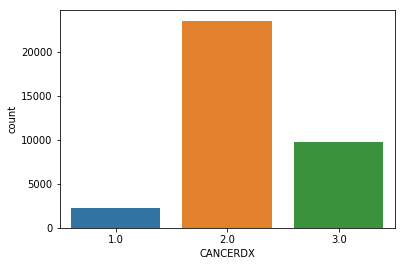

CHDDX


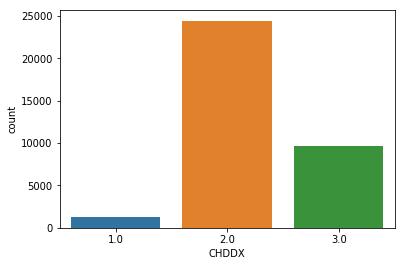

STRKDX


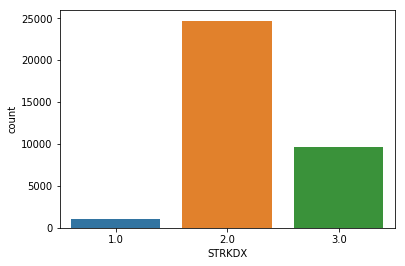

OHRTDX


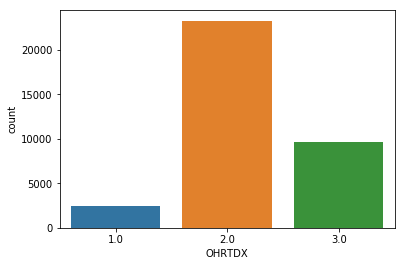

HIBPDX


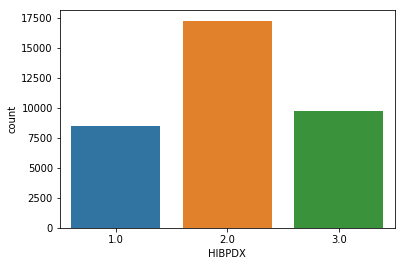

EMPHDX


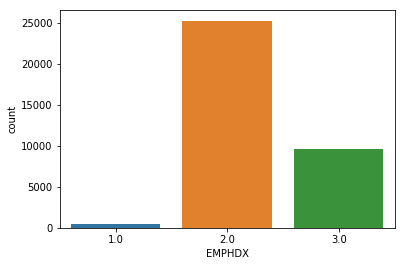

DIABDX


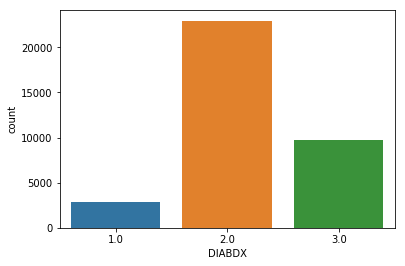

ARTHDX


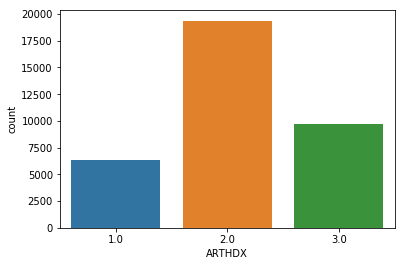

ASTHDX


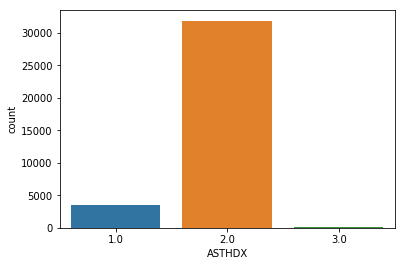

ADHDADDX


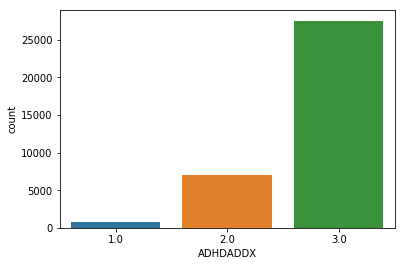

PREGNT31


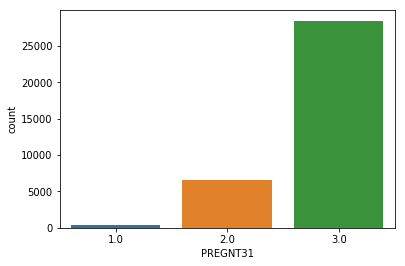

IADLHP31


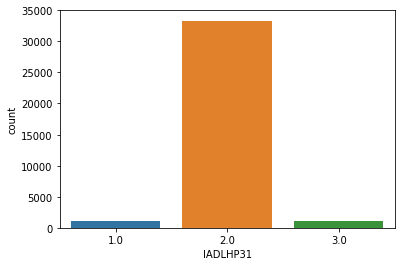

ADLHLP31


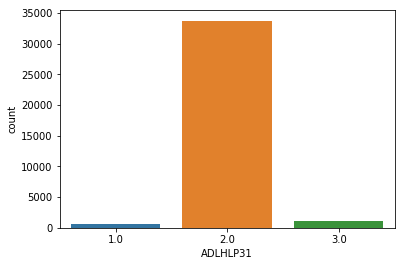

AIDHLP31


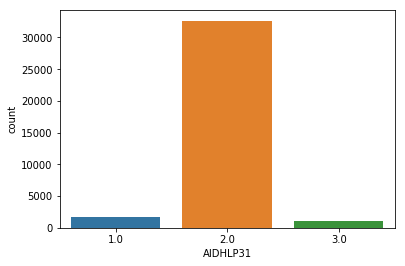

In [59]:
# count plot for each disease
for i, x in enumerate(disease_f):
    plt.figure(i)
    print(x)
    sns.countplot(df[x].fillna(3))
    plt.show()

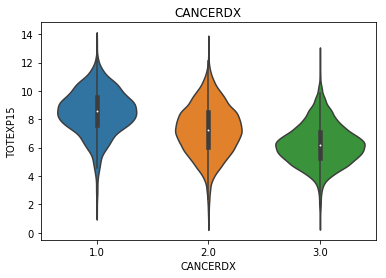

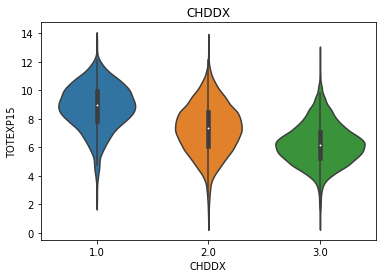

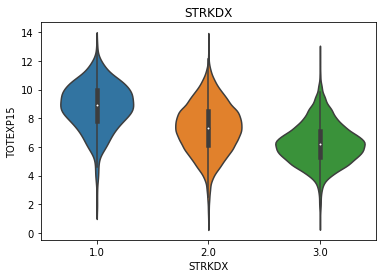

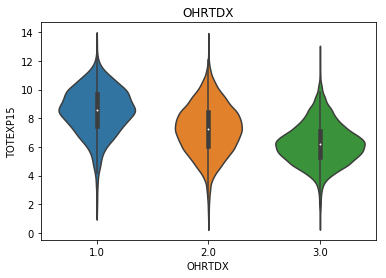

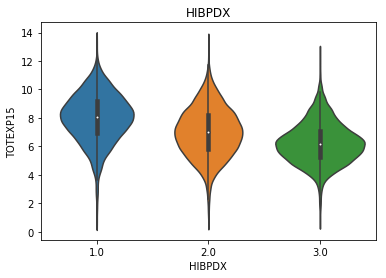

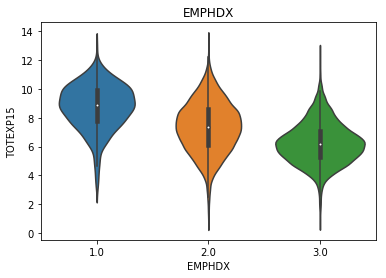

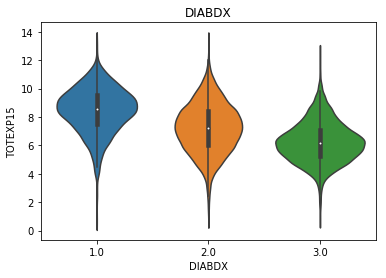

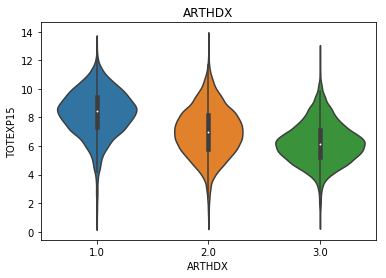

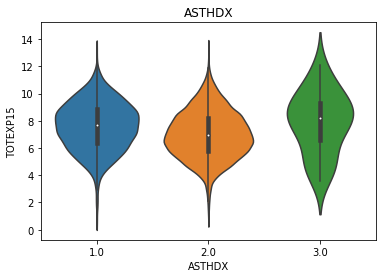

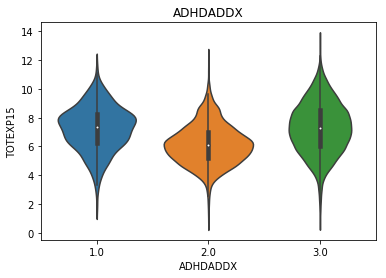

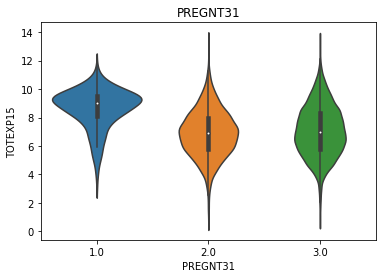

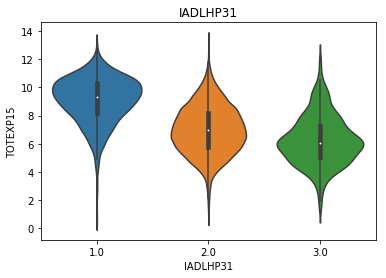

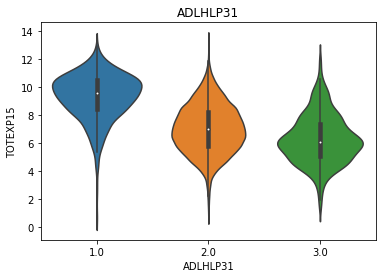

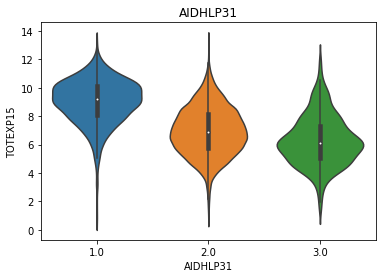

In [60]:
# plot expenditure across each disease
log_totexp = np.log(df.TOTEXP15+1)
df_explog = pd.concat([df.drop(["TOTEXP15"], axis=1), log_totexp], axis =1)
for i, cols in enumerate(disease_f):
    plt.figure(i)
    sns.violinplot(x=cols, y="TOTEXP15", data=df_explog[df_explog.TOTEXP15 >0] .fillna(3)).set_title(str(cols))
    plt.show() # this is different than 6.11plot as is acroos dis level

In [61]:
#######

In [62]:
###
df_mean = df.groupby(['CANCERDX']).mean()
print(df_mean.OBVEXP15) # office
print(df_mean.OPVEXP15) # out patient
print(df_mean.ERTEXP15) # emergency profit
print(df_mean.TOTEXP15) # total

CANCERDX
1.0    3349.815672
2.0     994.093106
Name: OBVEXP15, dtype: float64
CANCERDX
1.0    710.564114
2.0    193.467617
Name: OPVEXP15, dtype: float64
CANCERDX
1.0    333.402493
2.0    221.427702
Name: ERTEXP15, dtype: float64
CANCERDX
1.0    13391.691451
2.0     4414.898043
Name: TOTEXP15, dtype: float64


In [63]:
df_mean = df.groupby(['PREGNT31']).mean() 
print(df_mean.OBVEXP15) # office based 
print(df_mean.OPVEXP15) # out patient
print(df_mean.ERTEXP15) # emergency room expenditure
print(df_mean.TOTEXP15) # total

PREGNT31
1.0    1932.100503
2.0     867.481243
Name: OBVEXP15, dtype: float64
PREGNT31
1.0    221.087940
2.0    182.052825
Name: OPVEXP15, dtype: float64
PREGNT31
1.0    454.454774
2.0    210.892666
Name: ERTEXP15, dtype: float64
PREGNT31
1.0    10327.394472
2.0     2938.739550
Name: TOTEXP15, dtype: float64


In [64]:
df_mean = df.groupby(['STRKDX']).mean() #stroke
print(df_mean.OBVEXP15) # office
print(df_mean.OPVEXP15) # out patient
print(df_mean.ERTEXP15) # emergency profit
print(df_mean.TOTEXP15) # total
# 
print("-----------------")
#

df_mean = df.groupby(['CHDDX']).median()
print(df_mean.OBVEXP15)





STRKDX
1.0    2768.328571
2.0    1132.805287
Name: OBVEXP15, dtype: float64
STRKDX
1.0    491.140952
2.0    227.774683
Name: OPVEXP15, dtype: float64
STRKDX
1.0    555.519048
2.0    217.345181
Name: ERTEXP15, dtype: float64
STRKDX
1.0    18682.950476
2.0     4622.223536
Name: TOTEXP15, dtype: float64
-----------------
CHDDX
1.0    1079.5
2.0     193.0
Name: OBVEXP15, dtype: float64


In [65]:
df_mean = df.groupby(['DIABDX']).mean() #diabetes
print(df_mean.OBVEXP15) # office
print(df_mean.OPVEXP15) # out patient
print(df_mean.ERTEXP15) # emergency profit
print(df_mean.TOTEXP15) # total

DIABDX
1.0    2314.256675
2.0    1063.194725
Name: OBVEXP15, dtype: float64
DIABDX
1.0    405.881096
2.0    218.059983
Name: OPVEXP15, dtype: float64
DIABDX
1.0    303.432538
2.0    222.320445
Name: ERTEXP15, dtype: float64
DIABDX
1.0    12747.060164
2.0     4273.786225
Name: TOTEXP15, dtype: float64


In [124]:
# correlation matrix
df_exp = df.loc[:,"TOTEXP15":"RXEXP15"]
df_check_cor = pd.concat([df_c, df_exp.TOTEXP15],axis =1)
df_check_cor = df_check_cor.loc[:,~df_check_cor.columns.duplicated()]
df_check_cor = df_check_cor.filter(items = num_columns)
df_check_cor.rename(columns={"TOTEXP15": "Total_Expenditure", "RXTOT15": "Total Office_Based Visits",
                               "OBTOTV15": "Total Out_patients Visits", "TRBLE42": "Total Prescribed Medcine",
                               "HAVFUN42": "Age", "HOMEBH42": "Attitude towards Insurance",
                               "ADAPPT42": "Family Income Index", "ERTOT15": "TOTAL Emergency Room Visits",
                               "OPTOTV15": "BMI", "KIDPRO42": "Perceived Health Status",
                               "OBOTHV15": "Working Hours", "ASTHAGED": "Cancer Diagnosis",
                                "AGELAST": "Office Based Non-Physician Visits", "AGE53X": "Highest Education"}, inplace=True)
corr = df_check_cor.corr()
corr

FAMSZEYR  Highest Education  \
FAMSZEYR                           1.000000          -0.454152   
Highest Education                 -0.454152           1.000000   
Office Based Non-Physician Visits -0.454957           0.999918   
MARRY31X                           0.159860          -0.623679   
EDUYRDG                           -0.144932           0.066208   
EDRECODE                          -0.341420           0.449939   
HIBPAGED                          -0.198482           0.741372   
CHDAGED                           -0.229130           0.751920   
ANGIAGED                          -0.240105           0.713442   
MIAGED                            -0.199657           0.751632   
OHRTAGED                          -0.278819           0.749838   
STRKAGED                          -0.253565           0.834896   
EMPHAGED                          -0.072778           0.728459   
CHOLAGED                          -0.254395           0.829270   
DIABAGED                          -0.218713           0.764156   
ARTHAGED                          -0.230822           0.772485   
Cancer Diagnosis                  -0.318757           0.723172   
ADHDAGED                          -0.094890           0.458596   
MOMPRO42                          -0.047440           0.027201   
DADPRO42                          -0.117072           0.062278   
UNHAP42                           -0.021210           0.001249   
SCHLBH42                          -0.032918          -0.053349   
Age                               -0.022369           0.002375   
ADUPRO42                          -0.025109           0.007312   
NERVAF42                          -0.025169          -0.029600   
SIBPRO42                          -0.290403          -0.055602   
Perceived Health Status           -0.031736          -0.011035   
SPRPRO42                          -0.017573          -0.028367   
SCHPRO42                          -0.042196          -0.081124   
Attitude towards Insurance        -0.028393          -0.008923   
...                                     ...                ...   
CHECK53                            0.066022          -0.215665   
FLUSHT53                           0.099415          -0.240343   
PSA53                              0.218942          -0.435040   
PAPSMR53                          -0.065782           0.168224   
BRSTEX53                           0.057057          -0.108881   
MAMOGR53                           0.189648          -0.400497   
BSTST53                            0.104625          -0.251345   
CLNTST53                           0.198616          -0.354884   
SGMTST53                           0.053694          -0.117732   
BMINDX53                          -0.010579           0.065761   
SEATBE53                          -0.039958          -0.010536   
ADPRXY42                          -0.039324           0.083654   
Family Income Index               -0.176703           0.320813   
ADHECR42                          -0.026957           0.101569   
PCS42                              0.159484          -0.426856   
MCS42                              0.053875          -0.025315   
K6SUM42                           -0.094762           0.050486   
PHQ242                            -0.078070           0.071510   
ADCMPM42                          -0.002170          -0.023418   
DSA1C53                           -0.025324          -0.025703   
TYPEPE42                           0.009986          -0.052270   
HOUR31                            -0.033157           0.098927   
POVLEV15                          -0.174586           0.194513   
VETSP15X                          -0.044759           0.053212   
Total_Expenditure                 -0.146677           0.214632   
Total Out_patients Visits         -0.172734           0.223858   
Working Hours                     -0.108705           0.125746   
BMI                               -0.082637           0.116574   
TOTAL Emergency Room Visits       -0.090447           0.074616   
Total Off

In [125]:

corr.Total_Expenditure.sort_values(ascending=False)

Total_Expenditure                    1.000000
Total Office_Based Visits            0.413218
Total Out_patients Visits            0.374827
Total Prescribed Medcine             0.363849
Age                                  0.350828
Attitude towards Insurance           0.338262
Family Income Index                  0.306254
TOTAL Emergency Room Visits          0.276263
BMI                                  0.260768
Perceived Health Status              0.236084
Working Hours                        0.235925
Cancer Diagnosis                     0.222402
Office Based Non-Physician Visits    0.216429
Highest Education                    0.214632
CHAPPT42                             0.209309
ADUPRO42                             0.207228
SCHPRO42                             0.182936
OHRTAGED                             0.162739
SPRPRO42                             0.161596
K6SUM42                              0.153935
PHQ242                               0.148559
SCHLBH42                          

In [126]:
corr.Total_Expenditure.sort_values(ascending=False)

Total_Expenditure                    1.000000
Total Office_Based Visits            0.413218
Total Out_patients Visits            0.374827
Total Prescribed Medcine             0.363849
Age                                  0.350828
Attitude towards Insurance           0.338262
Family Income Index                  0.306254
TOTAL Emergency Room Visits          0.276263
BMI                                  0.260768
Perceived Health Status              0.236084
Working Hours                        0.235925
Cancer Diagnosis                     0.222402
Office Based Non-Physician Visits    0.216429
Highest Education                    0.214632
CHAPPT42                             0.209309
ADUPRO42                             0.207228
SCHPRO42                             0.182936
OHRTAGED                             0.162739
SPRPRO42                             0.161596
K6SUM42                              0.153935
PHQ242                               0.148559
SCHLBH42                          

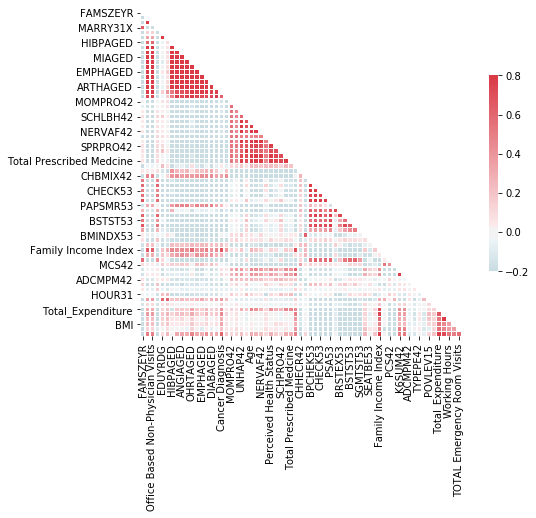

In [127]:
#plot corr matrix
corr = corr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = 1

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.8,vmin=-0.2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .6})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  9.8min finished


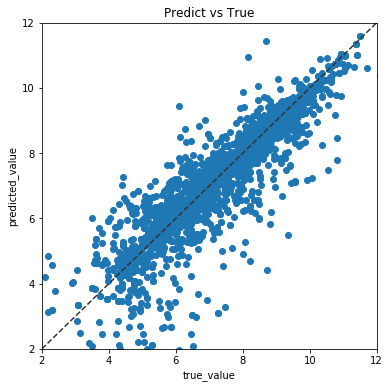

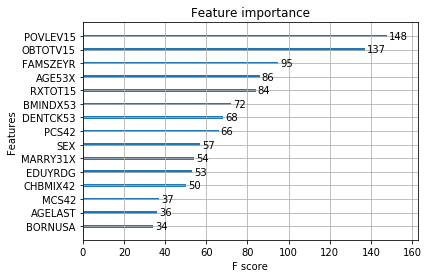

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100}
{'test R^2': 0.9482604156671363, 'training R^2': 0.9647949400124298, 'test mae': 0.44665195231074023, 'training mae': 0.39143639305303285, 'observations_count': 35427}
test R^2
-----
training R^2
-----
test mae
-----
training mae
-----
observations_count
-----


In [86]:
df_base = pd.concat([df_c, df["TOTEXP15"]],axis =1)
df_base = df_base.loc[:,~df_base.columns.duplicated()]
df_base = df_base.loc[(df_base["TOTEXP15" ])]   
#df_xgb_base = df_base
df_xgb_base = df_base.fillna(0)
df_xgb_base  = df_xgb_base.replace([np.inf, -np.inf], 0)
x = df_xgb_base.drop(['TOTEXP15'], axis=1)
y = np.log(df_xgb_base["TOTEXP15"]+1)
 
#x = preprocessing.scale(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state = 6)
#model fit  
xgb_model = XGBRegressor()
xgb_m = GridSearchCV(xgb_model,
                   {'max_depth': [3,4,5],
                    'n_estimators': [50,75,100],
                    "learning_rate": [0.1,0.2,0.3]
                   }, verbose=1, n_jobs=-1, cv=3)

xgb_m = xgb_m.fit(X=X_train,y=y_train)
train_mae = mean_absolute_error(y_train, xgb_m.predict(X_train))
test_mae = mean_absolute_error(y_test, xgb_m.predict(X_test))

    #plt1
pred = xgb_m.predict(X_test)
true = y_test
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(true, pred )
ax.set_xlim([2, 12])
ax.set_ylim([2, 12])
plt.title("Predict vs True")
plt.xlabel("true_value")
plt.ylabel("predicted_value")
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".2")
plt.show()
    
    #plt2
params = xgb_m.best_params_
model  = XGBRegressor(params["max_depth"], params["learning_rate"], params["n_estimators"])
model.fit(X_train, y_train)
plt.figure()
xgb.plot_importance(model, max_num_features=15)
plt.show()

print (xgb_m.best_params_)
ret={}
ret["test R^2"] = xgb_m.best_score_  
ret["training R^2"] =  xgb_m.score(X=X_train,y=y_train) 
ret["test mae"] = test_mae  
ret["training mae"] =  train_mae   
ret["observations_count"] =  len(y)
print(ret)
'''
for x in ret:
    print(x)
    print("-----")
'''

In [ ]:
## notice self imputed data performs worse than xgb imputed num

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 20.4min finished


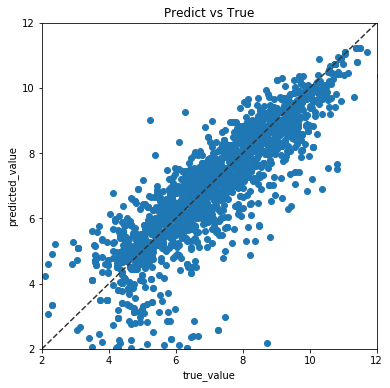

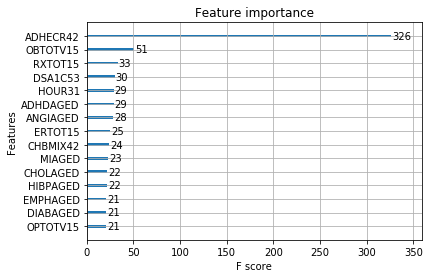

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 75}
{'test R^2': 0.9467046386591372, 'training R^2': 0.9527039843932477, 'test mae': 0.5088554615757112, 'training mae': 0.47410870233848884, 'observations_count': 35427}


In [93]:
df_base = pd.concat([df_preprocessed, df["TOTEXP15"]],axis =1)
df_base = df_base.loc[:,~df_base.columns.duplicated()]
df_base = df_base.loc[(df_base["TOTEXP15" ])]   
df_xgb_base = df_base.fillna(0)
df_xgb_base.replace([np.inf, -np.inf], 0)
y = np.log(df_xgb_base["TOTEXP15"]+1)
x = df_xgb_base.drop(['TOTEXP15'], axis=1)



X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state = 6)
    #model fit  
xgb_model = XGBRegressor()
xgb_m = GridSearchCV(xgb_model,
                   {'max_depth': [3,4,5],
                    'n_estimators': [50,75],
                    "learning_rate": [0.1,0.2,0.3]
                   }, verbose=1, n_jobs=-1, cv=3)

xgb_m = xgb_m.fit(X=X_train,y=y_train)
train_mae = mean_absolute_error(y_train, xgb_m.predict(X_train))
test_mae = mean_absolute_error(y_test, xgb_m.predict(X_test))

    #plt1
pred = xgb_m.predict(X_test)
true = y_test
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(true, pred )
ax.set_xlim([2, 12])
ax.set_ylim([2, 12])
plt.title("Predict vs True")
plt.xlabel("true_value")
plt.ylabel("predicted_value")
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".2")
plt.show()
    
    #plt2
params = xgb_m.best_params_
model  = XGBRegressor(params["max_depth"], params["learning_rate"], params["n_estimators"])
model.fit(X_train, y_train)
plt.figure()
xgb.plot_importance(model, max_num_features=15)
plt.show()

print (xgb_m.best_params_)
ret={}
ret["test R^2"] = xgb_m.best_score_  
ret["training R^2"] =  xgb_m.score(X=X_train,y=y_train) 
ret["test mae"] = test_mae  
ret["training mae"] =  train_mae   
ret["observations_count"] =  len(y)
print(ret)
#####

# 3. Model fit, diagonosed patient to specific expenditure

In [8]:
# fit model/plot
def DvsE_out_plot(d,e,df_input,df_all):
    '''
    disease vs expenditure;
    input：
        df_input is feature df which contains feacture of interests
        df_all is the whole df for extracting disease and expenditure;
    return:
        (plot feature importance to explore)
        train/ test R^2 and MAE, and sample counts
    '''
    #input
    df_c = df_input
    df=df_all
    df_c = pd.concat([df_c, df[e]],axis =1)
    df_c = df_c.loc[:,~df_c.columns.duplicated()]
    df_cheart = df_c.loc[(df_c[d] == 1) & (df_c[e] > 0) ]   
    
    #preprocess
    y = np.log(df_cheart[e]+1)        
    if len(y) < 10:
        ret = "observation count smaller than 10"
        print(d,"obervation count smaller than 10")
        return ret
    x = df_cheart.drop([e], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 6)
    #model fit  
    xgb_model = XGBRegressor()
    xgb_m = GridSearchCV(xgb_model,
                   {'max_depth': [2,3,5],
                    'n_estimators': [25,45,65],
                    "learning_rate": [0.1,0.2,0.3]
                   }, verbose=1, n_jobs=-1, cv=3)

    xgb_m = xgb_m.fit(X=X_train,y=y_train)
    train_mae = mean_absolute_error(y_train, xgb_m.predict(X_train))
    test_mae = mean_absolute_error(y_test, xgb_m.predict(X_test))

    #plt1
    pred = xgb_m.predict(X_test)
    true = y_test
    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(true, pred )
    ax.set_xlim([0, 12])
    ax.set_ylim([0, 12])
    plt.title("Predict vs True")
    plt.xlabel("true_value")
    plt.ylabel("predicted_value")
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    plt.show()
    
    #plt2
    params = xgb_m.best_params_
    model  = XGBRegressor(params["max_depth"], params["learning_rate"], params["n_estimators"])
    model.fit(X_train, y_train)
    plt.figure()
    xgb.plot_importance(model, max_num_features=15)
    plt.show()
    #return
    print (xgb_m.best_params_)
    ret={}
    ret["test R^2"] = xgb_m.best_score_  
    #ret["training R^2"] =  xgb_m.score(X=X_train,y=y_train) 
    #ret["test mae"] = test_mae  
    #ret["training mae"] =  train_mae   
    ret["observations_count"] =  len(y)

    return ret


In [8]:
df_input = df_c
df_all = df

# coronary heart disease

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   28.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


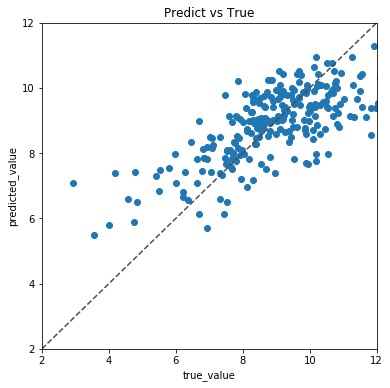

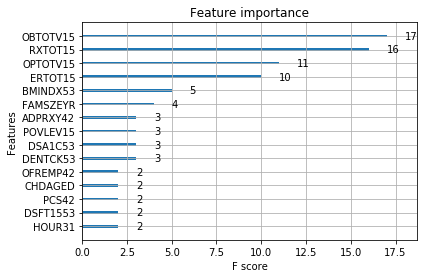

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50}


{'observations_count': 1256,
 'test R^2': 0.5394685907729895,
 'test mae': 0.8961343399092596,
 'training R^2': 0.7048031940884515,
 'training mae': 0.6596149146217025}

In [131]:
# explore coronary heart disease vs TOTEXP
DvsE_out_plot('CHDDX','TOTEXP15',df_input,df_all)

In [166]:
DvsE_out('CHDDX','TOTEXP15',df_input,df_all)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   30.7s finished


{'observations_count': 1290,
 'test R^2': 0.6983225429845477,
 'test mae': 0.9767107473442648,
 'training R^2': 0.8802261728945496,
 'training mae': 0.563255302464367}

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   26.6s finished


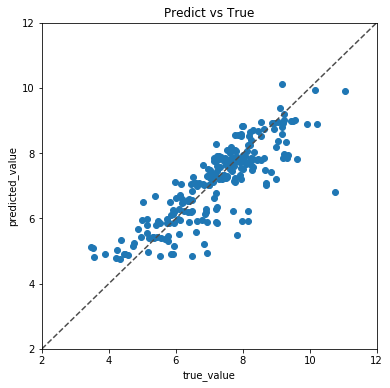

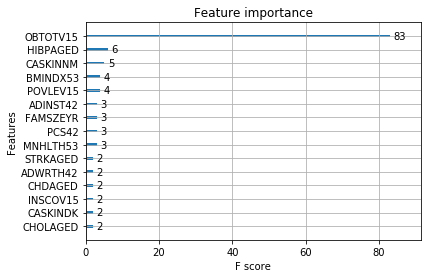

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}


{'observations_count': 1171,
 'test R^2': 0.723673033334872,
 'test mae': 0.5535039942438549,
 'training R^2': 0.7710698373609801,
 'training mae': 0.490207104241209}

In [132]:
# explore coronary heart disease vs office based exp
DvsE_out_plot('CHDDX','OBVEXP15',df_input,df_all)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   20.8s finished


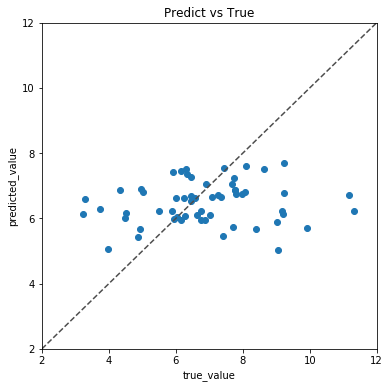

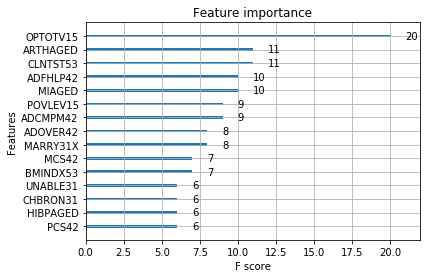

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


{'observations_count': 289,
 'test R^2': -0.02387128174215062,
 'test mae': 1.3885496142580205,
 'training R^2': 0.7780351097943198,
 'training mae': 0.6371446198493126}

In [133]:
# explore coronary heart disease vs outpatient based exp
DvsE_out_plot('CHDDX','OPVEXP15',df_input,df_all)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   26.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


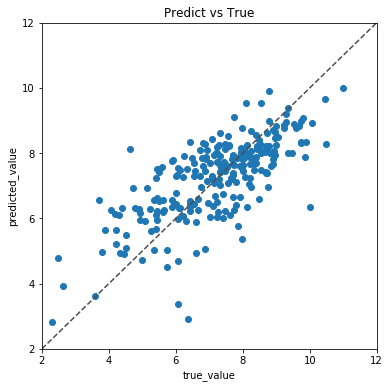

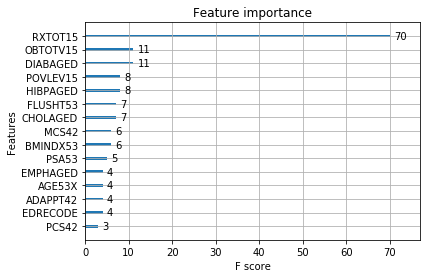

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 75}


{'observations_count': 1209,
 'test R^2': 0.6230316135229346,
 'test mae': 0.861622921307236,
 'training R^2': 0.7308444350805714,
 'training mae': 0.7144983086918879}

In [134]:
# explore coronary heart disease vs outpatient based exp
DvsE_out_plot('CHDDX','RXEXP15',df_input,df_all)

# preganant

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   19.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


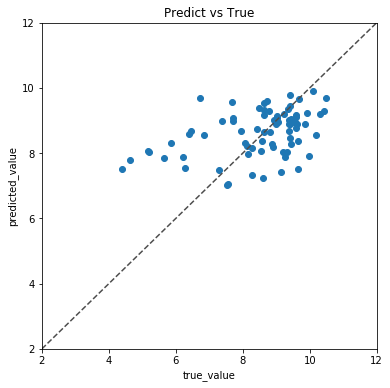

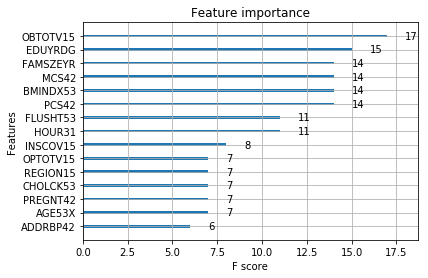

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


{'observations_count': 380,
 'test R^2': 0.145746931206345,
 'test mae': 0.9674326854001325,
 'training R^2': 0.7142713969507406,
 'training mae': 0.5769362234143682}

In [125]:
# explore coronary heart disease vs outpatient based exp
DvsE_out_plot('PREGNT31','TOTEXP15',df_input,df_all)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   19.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


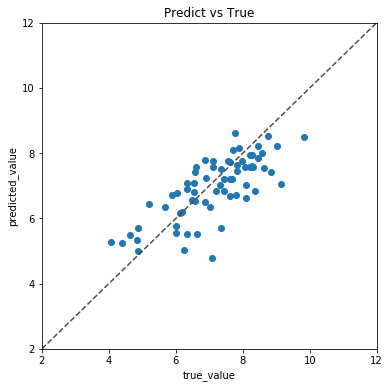

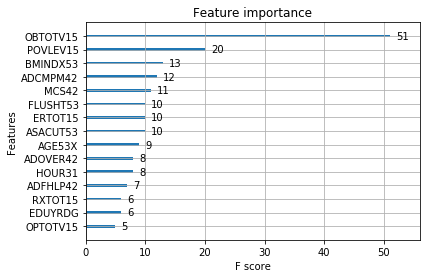

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


{'observations_count': 339,
 'test R^2': 0.4960027080003214,
 'test mae': 0.6744314195696273,
 'training R^2': 0.8515594530367072,
 'training mae': 0.38958074127162934}

In [126]:
# explore coronary heart disease vs outpatient based exp
DvsE_out_plot('PREGNT31','OBVEXP15',df_input,df_all)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   16.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


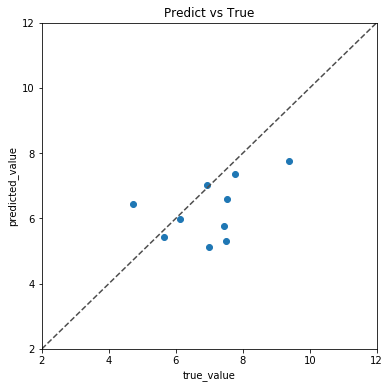

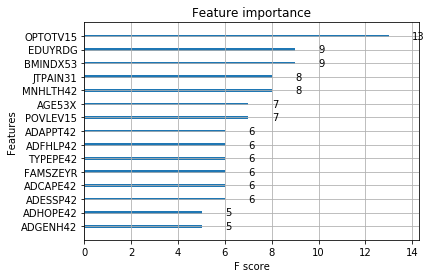

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 25}


{'observations_count': 50,
 'test R^2': -0.5488691283949321,
 'test mae': 1.0938154801830318,
 'training R^2': 0.9965480757182692,
 'training mae': 0.058604034320640305}

In [127]:
# explore coronary heart disease vs outpatient based exp
DvsE_out_plot('PREGNT31','OPVEXP15',df_input,df_all)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   18.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


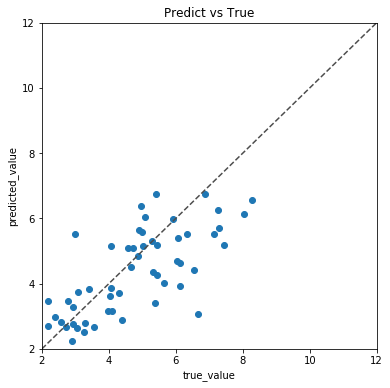

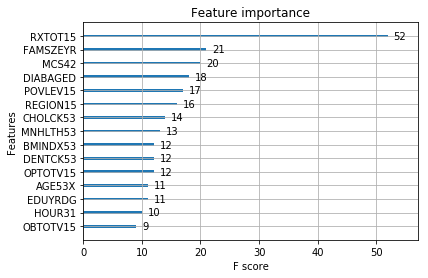

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 80}


{'observations_count': 275,
 'test R^2': 0.40499188645455075,
 'test mae': 0.9586731793357812,
 'training R^2': 0.933058844977047,
 'training mae': 0.3359852890838969}

In [128]:
DvsE_out_plot('PREGNT31','RXEXP15',df_input,df_all)

# classifier

In [11]:

def DvsE_cls(d,e,df_input,df_all):
    #input
    df_c = df_input
    df=df_all
    
    df_c = pd.concat([df_c, df[e]],axis =1)
    df_c = df_c.loc[:,~df_c.columns.duplicated()]
    df_cheart = df_c.loc[(df_c[d] == 1)]
    
    #preprocess
    y = (df_cheart[e])
    #print(y)
    y = pd.cut(y,3, labels=["low","medium","high"])     ## low value vs high value      
    #print(y)
    x = df_cheart.drop([e], axis=1)
    #x = preprocessing.scale(x)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 6)
    #print(y_train)
    #print(y_test)
    xgb_model = XGBClassifier()
    xgb_m = GridSearchCV(xgb_model,
                   {'max_depth': [3,4,5],
                    'n_estimators': [25,50,75],
                    "learning_rate": [0.1,0.2,0.3]
                   }, verbose=1, n_jobs=-1, cv=3)
    xgb_m = xgb_m.fit(X=X_train,y=y_train)
    test_acc = accuracy_score(y_test, xgb_m.predict(X_test))
    
    ret_dic = {}
    ret_dic["train_acc"] = xgb_m.best_score_
    ret_dic["test_acc"] = test_acc
    ret_dic["parameter"] = xgb_m.best_params_
    print(len(y))
    return ret_dic


In [162]:
print(DvsE_cls('CANCERDX','TOTEXP15',df_c,df))
print(DvsE_cls('CHDDX','OBVEXP15',df_c,df))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   25.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


2246
{'train_acc': 0.9988864142538976, 'test_acc': 1.0, 'parameter': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 25}}
Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   23.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1290
{'train_acc': 0.999031007751938, 'test_acc': 1.0, 'parameter': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 25}}


# output disease vs expenditure model performance and summary stats

In [9]:

disease_f = ["CANCERDX", "CHDDX","STRKDX","OHRTDX","HIBPDX","EMPHDX","DIABDX",
#cancer/ coronary heart disease/ stroke/ other heart disease/ high blood pressure/ Emphysema肺气肿/Diabetes糖尿病
            "ARTHDX", "ASTHDX", "ADHDADDX","PREGNT31","IADLHP31"]
#           arthritis关节炎/asthma/ 多动症/ pregnant / independent living screener


exp_l = ["TOTEXP15", "OPTEXP15", "OBVEXP15",   "HHAEXP15",               "ERTEXP15","IPTEXP15", "RXEXP15"]


In [10]:
def summary_y(d,e,df_input,df_all):
    '''
    disease vs expenditure;
    df_input is feature df
    df_all is the whole df for extracting d and e;
    return train/ test R^2 and MAE.
    '''
    #input
    df_c = df_input
    df=df_all
    df_c = pd.concat([df_c, df[e]],axis =1)
    df_c = df_c.loc[:,~df_c.columns.duplicated()]
    df_cheart = df_c.loc[(df_c[d] == 1) & (df_c[e] >0)]
    #preprocess
    y =    df_cheart[e]
    #plt.figure()
   # sns.distplot(y)
   # plt.show()   
    
    plt.figure()
    sns.distplot(np.log(y+10))
    plt.show() 
    if len(y) < 10:
        ret = "observation count smaller than 10"
        print(d,"obervation count smaller than 10")
        return ret
    x = df_cheart.drop([e], axis=1)

    return y.describe()

----------------------------------
0
CANCERDX
TOTEXP15


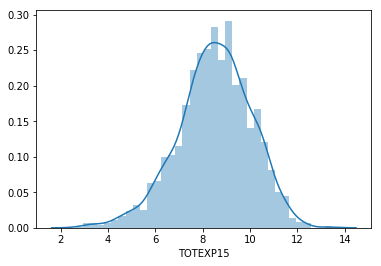

count      2170.000000
mean      13860.709217
std       29427.119742
min           4.000000
25%        1931.500000
50%        5179.000000
75%       14308.500000
max      700771.000000
Name: TOTEXP15, dtype: float64
----------------------------------
1
CANCERDX
OPTEXP15


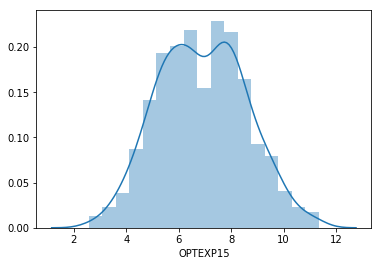

count      752.000000
mean      3691.710106
std       8639.432302
min          3.000000
25%        268.500000
50%        929.500000
75%       3223.250000
max      84746.000000
Name: OPTEXP15, dtype: float64
----------------------------------
2
CANCERDX
OBVEXP15


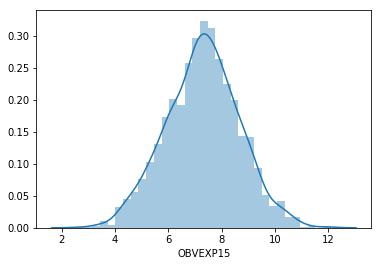

count      2042.000000
mean       3684.469148
std        8307.536792
min           3.000000
25%         563.500000
50%        1482.000000
75%        3598.750000
max      178468.000000
Name: OBVEXP15, dtype: float64
----------------------------------
3
CANCERDX
HHAEXP15


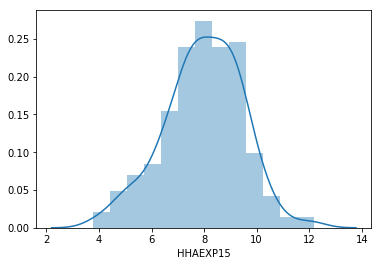

count       220.000000
mean       8100.122727
std       19657.491202
min          34.000000
25%        1162.750000
50%        3020.500000
75%        8472.750000
max      198046.000000
Name: HHAEXP15, dtype: float64
----------------------------------
4
CANCERDX
ERTEXP15


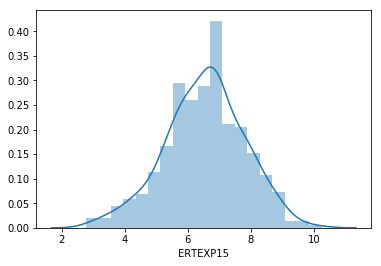

count      518.000000
mean      1445.602317
std       2341.091318
min          6.000000
25%        301.500000
50%        723.000000
75%       1551.500000
max      28333.000000
Name: ERTEXP15, dtype: float64
----------------------------------
5
CANCERDX
IPTEXP15


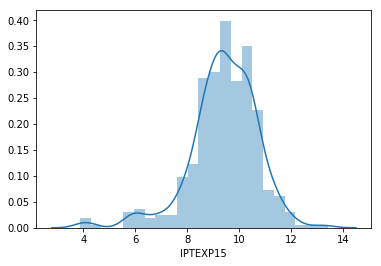

count       393.000000
mean      24797.376590
std       46807.703342
min          38.000000
25%        6329.000000
50%       12477.000000
75%       28994.000000
max      663917.000000
Name: IPTEXP15, dtype: float64
----------------------------------
6
CANCERDX
RXEXP15


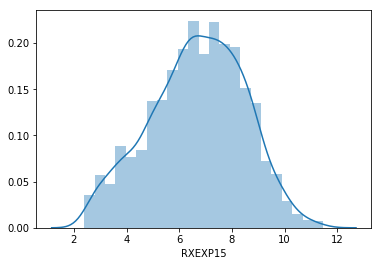

count     2013.000000
mean      3015.944858
std       6779.884382
min          1.000000
25%        228.000000
50%        848.000000
75%       2946.000000
max      95671.000000
Name: RXEXP15, dtype: float64
----------------------------------
7
CHDDX
TOTEXP15


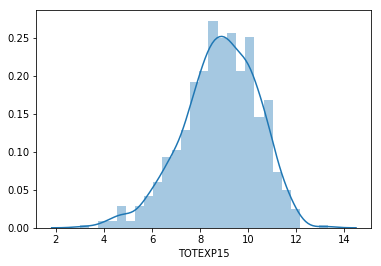

count      1256.000000
mean      18183.140924
std       33581.368129
min          10.000000
25%        2638.750000
50%        7617.000000
75%       20967.000000
max      608264.000000
Name: TOTEXP15, dtype: float64
----------------------------------
8
CHDDX
OPTEXP15


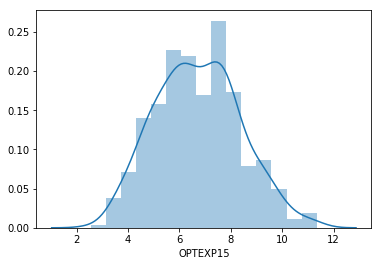

count      453.000000
mean      3189.139073
std       8223.363006
min          3.000000
25%        244.000000
50%        759.000000
75%       2393.000000
max      83416.000000
Name: OPTEXP15, dtype: float64
----------------------------------
9
CHDDX
OBVEXP15


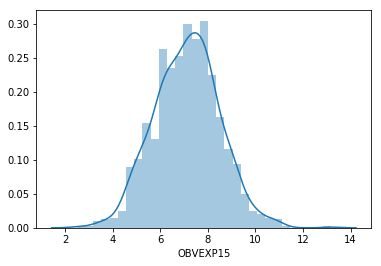

count      1171.000000
mean       3489.941076
std       16474.322768
min           2.000000
25%         466.500000
50%        1311.000000
75%        2990.000000
max      526744.000000
Name: OBVEXP15, dtype: float64
----------------------------------
10
CHDDX
HHAEXP15


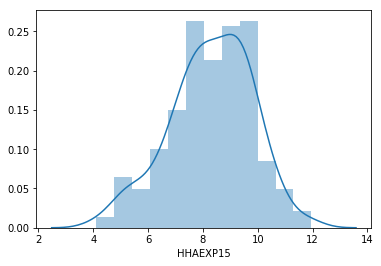

count       215.000000
mean      10255.213953
std       18362.060470
min          51.000000
25%        1620.000000
50%        4212.000000
75%       12360.500000
max      155022.000000
Name: HHAEXP15, dtype: float64
----------------------------------
11
CHDDX
ERTEXP15


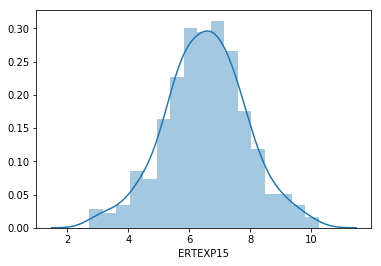

count      398.000000
mean      1614.776382
std       2973.113058
min          5.000000
25%        276.000000
50%        691.500000
75%       1597.500000
max      28333.000000
Name: ERTEXP15, dtype: float64
----------------------------------
12
CHDDX
IPTEXP15


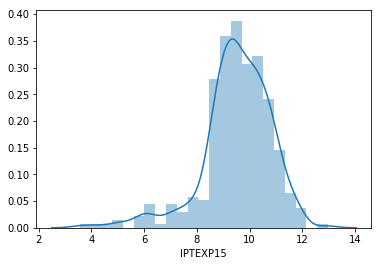

count       334.000000
mean      25626.676647
std       34779.441283
min          25.000000
25%        7470.250000
50%       13992.000000
75%       31750.750000
max      430298.000000
Name: IPTEXP15, dtype: float64
----------------------------------
13
CHDDX
RXEXP15


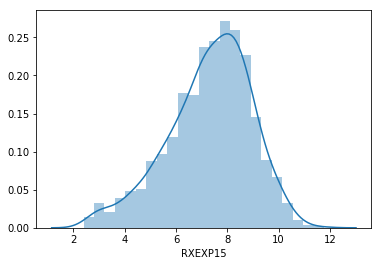

count      1209.000000
mean       4141.463193
std        7455.813894
min           1.000000
25%         534.000000
50%        1781.000000
75%        4791.000000
max      129817.000000
Name: RXEXP15, dtype: float64
----------------------------------
14
STRKDX
TOTEXP15


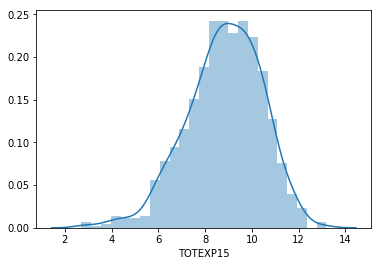

count      1013.000000
mean      19365.348470
std       36622.614907
min           5.000000
25%        2443.000000
50%        7470.000000
75%       21056.000000
max      530792.000000
Name: TOTEXP15, dtype: float64
----------------------------------
15
STRKDX
OPTEXP15


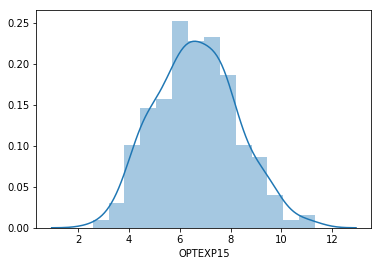

count      316.000000
mean      2907.164557
std       7761.035309
min          3.000000
25%        235.500000
50%        730.000000
75%       2229.250000
max      83416.000000
Name: OPTEXP15, dtype: float64
----------------------------------
16
STRKDX
OBVEXP15


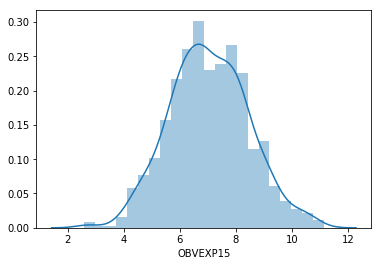

count      934.000000
mean      3112.146681
std       6426.993434
min          3.000000
25%        428.000000
50%       1062.500000
75%       2979.000000
max      69537.000000
Name: OBVEXP15, dtype: float64
----------------------------------
17
STRKDX
HHAEXP15


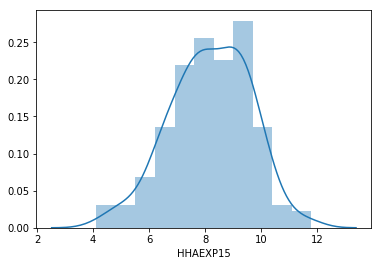

count       190.000000
mean       8719.394737
std       15522.360082
min          51.000000
25%        1315.750000
50%        3720.500000
75%       10183.750000
max      131888.000000
Name: HHAEXP15, dtype: float64
----------------------------------
18
STRKDX
ERTEXP15


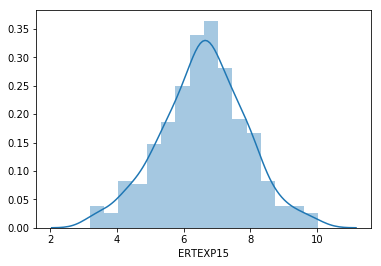

count      365.000000
mean      1598.068493
std       2751.344608
min         14.000000
25%        322.000000
50%        742.000000
75%       1598.000000
max      22870.000000
Name: ERTEXP15, dtype: float64
----------------------------------
19
STRKDX
IPTEXP15


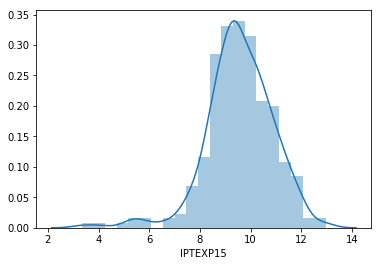

count       283.000000
mean      29486.459364
std       45988.863797
min          18.000000
25%        6677.500000
50%       13429.000000
75%       31687.000000
max      430298.000000
Name: IPTEXP15, dtype: float64
----------------------------------
20
STRKDX
RXEXP15


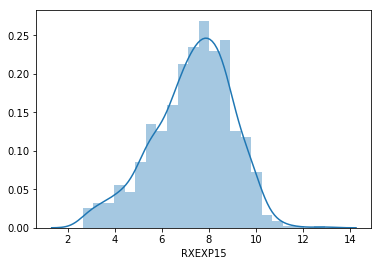

count       964.000000
mean       4739.189834
std       15418.300506
min           4.000000
25%         523.000000
50%        1803.000000
75%        4916.250000
max      414941.000000
Name: RXEXP15, dtype: float64
----------------------------------
21
OHRTDX
TOTEXP15


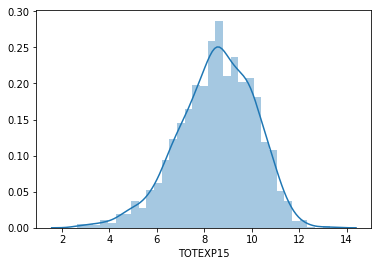

count      2370.000000
mean      14087.199156
std       27857.680988
min           4.000000
25%        1776.250000
50%        5378.000000
75%       15953.250000
max      608264.000000
Name: TOTEXP15, dtype: float64
----------------------------------
22
OHRTDX
OPTEXP15


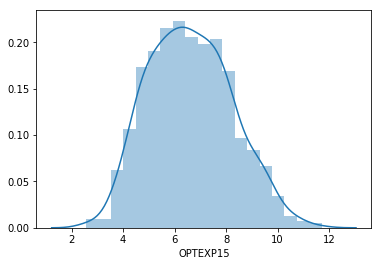

count       837.000000
mean       2819.206691
std        7531.657360
min           3.000000
25%         209.000000
50%         670.000000
75%        2258.000000
max      121690.000000
Name: OPTEXP15, dtype: float64
----------------------------------
23
OHRTDX
OBVEXP15


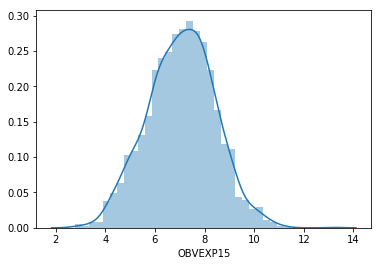

count      2199.000000
mean       3066.876762
std       12422.503470
min           6.000000
25%         451.000000
50%        1206.000000
75%        2936.500000
max      526744.000000
Name: OBVEXP15, dtype: float64
----------------------------------
24
OHRTDX
HHAEXP15


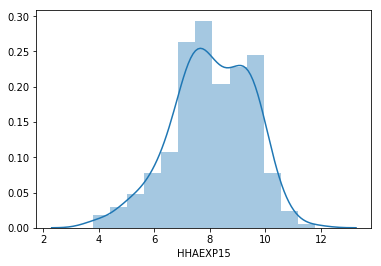

count       271.000000
mean       7334.011070
std       11537.695794
min          34.000000
25%        1307.000000
50%        3074.000000
75%        9944.000000
max      131888.000000
Name: HHAEXP15, dtype: float64
----------------------------------
25
OHRTDX
ERTEXP15


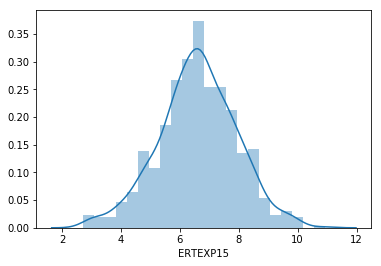

count      695.000000
mean      1716.684892
std       3441.602339
min          5.000000
25%        323.500000
50%        741.000000
75%       1757.500000
max      55261.000000
Name: ERTEXP15, dtype: float64
----------------------------------
26
OHRTDX
IPTEXP15


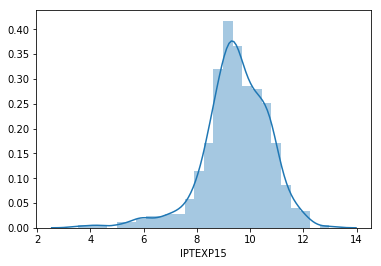

count       483.000000
mean      24013.213251
std       33380.971041
min          25.000000
25%        6856.500000
50%       13092.000000
75%       29837.000000
max      430298.000000
Name: IPTEXP15, dtype: float64
----------------------------------
27
OHRTDX
RXEXP15


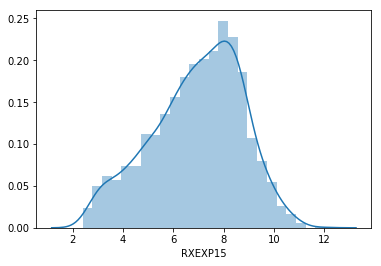

count      2192.000000
mean       3597.596715
std        7410.696040
min           1.000000
25%         302.750000
50%        1247.000000
75%        3935.500000
max      168967.000000
Name: RXEXP15, dtype: float64
----------------------------------
28
HIBPDX
TOTEXP15


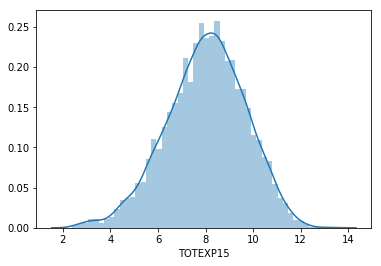

count      7890.000000
mean      10035.796198
std       22939.658200
min           1.000000
25%        1052.250000
50%        3283.500000
75%        9695.000000
max      700771.000000
Name: TOTEXP15, dtype: float64
----------------------------------
29
HIBPDX
OPTEXP15


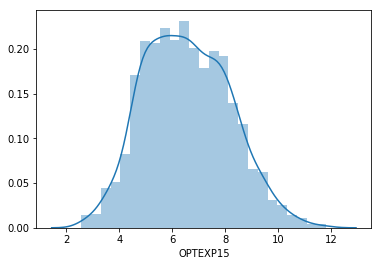

count      2055.000000
mean       2667.537226
std        7610.746933
min           3.000000
25%         191.000000
50%         642.000000
75%        2245.500000
max      134843.000000
Name: OPTEXP15, dtype: float64
----------------------------------
30
HIBPDX
OBVEXP15


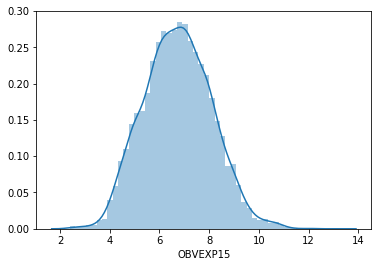

count      7125.000000
mean       2276.283088
std        8277.620600
min           1.000000
25%         316.000000
50%         822.000000
75%        2149.000000
max      526744.000000
Name: OBVEXP15, dtype: float64
----------------------------------
31
HIBPDX
HHAEXP15


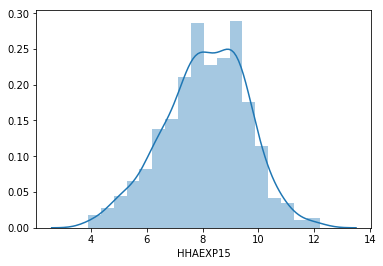

count       629.000000
mean       8803.821940
std       17403.235013
min          39.000000
25%        1287.000000
50%        3602.000000
75%        9706.000000
max      198046.000000
Name: HHAEXP15, dtype: float64
----------------------------------
32
HIBPDX
ERTEXP15


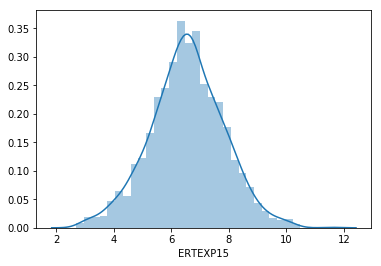

count      1734.000000
mean       1593.212803
std        3699.818870
min           5.000000
25%         302.250000
50%         696.500000
75%        1578.500000
max      104277.000000
Name: ERTEXP15, dtype: float64
----------------------------------
33
HIBPDX
IPTEXP15


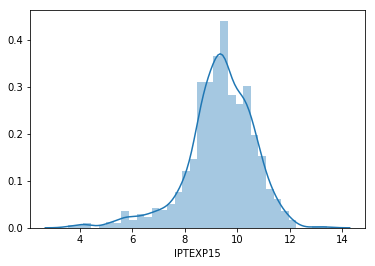

count      1087.000000
mean      21975.540938
std       34268.497184
min          25.000000
25%        6098.500000
50%       12407.000000
75%       27130.000000
max      663917.000000
Name: IPTEXP15, dtype: float64
----------------------------------
34
HIBPDX
RXEXP15


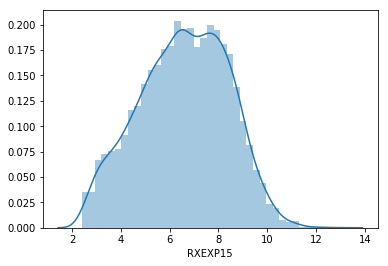

count      7349.000000
mean       2899.065451
std        8656.294799
min           1.000000
25%         185.000000
50%         759.000000
75%        2844.000000
max      414941.000000
Name: RXEXP15, dtype: float64
----------------------------------
35
EMPHDX
TOTEXP15


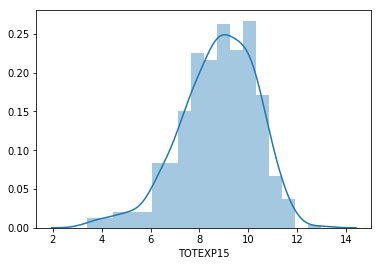

count       452.000000
mean      16158.426991
std       28147.618666
min          20.000000
25%        2410.000000
50%        7032.000000
75%       20551.000000
max      423121.000000
Name: TOTEXP15, dtype: float64
----------------------------------
36
EMPHDX
OPTEXP15


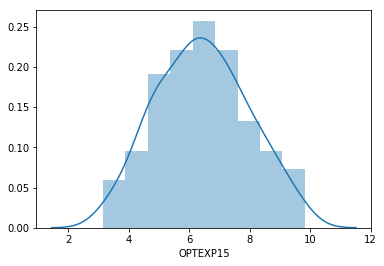

count      183.000000
mean      1770.688525
std       3050.548179
min         13.000000
25%        194.000000
50%        571.000000
75%       1683.500000
max      18505.000000
Name: OPTEXP15, dtype: float64
----------------------------------
37
EMPHDX
OBVEXP15


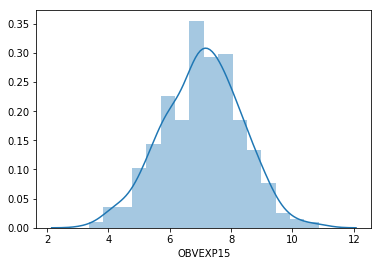

count      415.000000
mean      2546.028916
std       4680.951104
min         19.000000
25%        461.000000
50%       1163.000000
75%       2788.500000
max      51870.000000
Name: OBVEXP15, dtype: float64
----------------------------------
38
EMPHDX
HHAEXP15


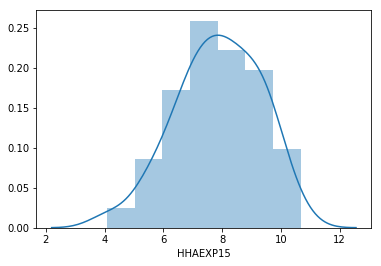

count       86.000000
mean      5912.674419
std       7714.773504
min         49.000000
25%        957.750000
50%       2459.500000
75%       9004.000000
max      43515.000000
Name: HHAEXP15, dtype: float64
----------------------------------
39
EMPHDX
ERTEXP15


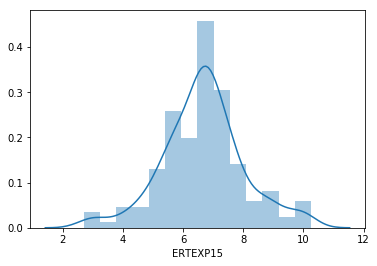

count      158.000000
mean      2073.993671
std       4240.298174
min          5.000000
25%        347.750000
50%        780.500000
75%       1592.750000
max      28333.000000
Name: ERTEXP15, dtype: float64
----------------------------------
40
EMPHDX
IPTEXP15


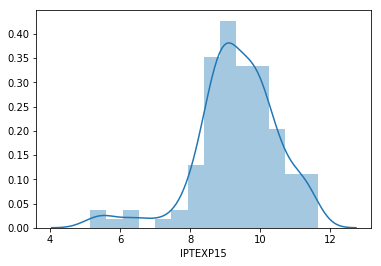

count       116.000000
mean      19466.327586
std       21620.414386
min         161.000000
25%        6592.000000
50%       11477.000000
75%       21997.750000
max      114057.000000
Name: IPTEXP15, dtype: float64
----------------------------------
41
EMPHDX
RXEXP15


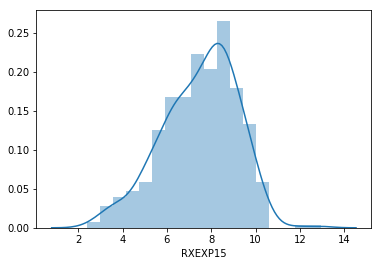

count       438.000000
mean       5902.748858
std       21473.491800
min           1.000000
25%         553.500000
50%        2083.500000
75%        5857.250000
max      414941.000000
Name: RXEXP15, dtype: float64
----------------------------------
42
DIABDX
TOTEXP15


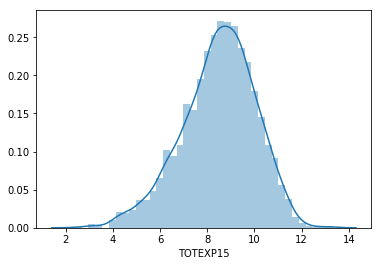

count      2715.000000
mean      13188.394843
std       26790.965091
min           1.000000
25%        1869.000000
50%        5387.000000
75%       14334.500000
max      608264.000000
Name: TOTEXP15, dtype: float64
----------------------------------
43
DIABDX
OPTEXP15


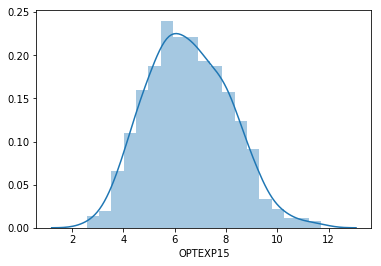

count       753.000000
mean       2779.197875
std        8801.178013
min           3.000000
25%         211.000000
50%         645.000000
75%        2208.000000
max      121690.000000
Name: OPTEXP15, dtype: float64
----------------------------------
44
DIABDX
OBVEXP15


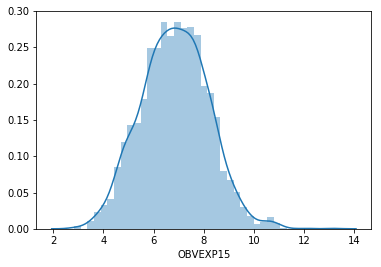

count      2510.000000
mean       2589.939044
std       12118.552347
min           7.000000
25%         366.250000
50%         931.000000
75%        2332.500000
max      526744.000000
Name: OBVEXP15, dtype: float64
----------------------------------
45
DIABDX
HHAEXP15


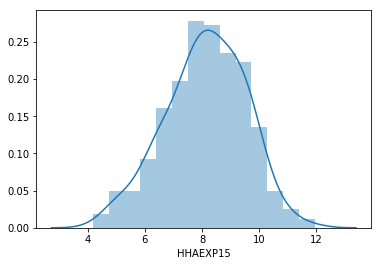

count       291.000000
mean       7957.460481
std       13892.233436
min          55.000000
25%        1374.500000
50%        3760.000000
75%        9372.500000
max      155022.000000
Name: HHAEXP15, dtype: float64
----------------------------------
46
DIABDX
ERTEXP15


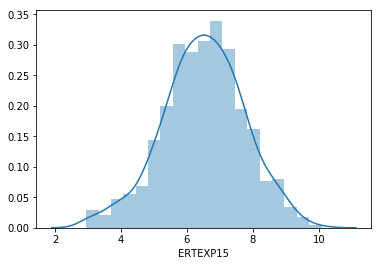

count      627.000000
mean      1359.397129
std       2092.706441
min          9.000000
25%        295.000000
50%        684.000000
75%       1517.500000
max      24004.000000
Name: ERTEXP15, dtype: float64
----------------------------------
47
DIABDX
IPTEXP15


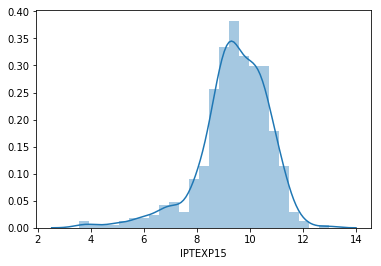

count       444.000000
mean      23023.405405
std       31134.521241
min          25.000000
25%        6582.250000
50%       13101.500000
75%       29035.000000
max      430298.000000
Name: IPTEXP15, dtype: float64
----------------------------------
48
DIABDX
RXEXP15


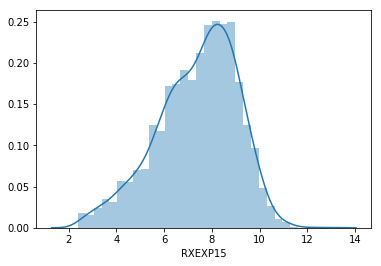

count      2635.000000
mean       4740.054649
std       11247.662413
min           1.000000
25%         529.000000
50%        2023.000000
75%        5578.500000
max      414941.000000
Name: RXEXP15, dtype: float64
----------------------------------
49
ARTHDX
TOTEXP15


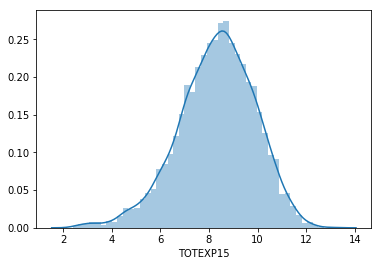

count      6066.000000
mean      11486.399275
std       21757.133632
min           1.000000
25%        1505.750000
50%        4526.000000
75%       12293.500000
max      530792.000000
Name: TOTEXP15, dtype: float64
----------------------------------
50
ARTHDX
OPTEXP15


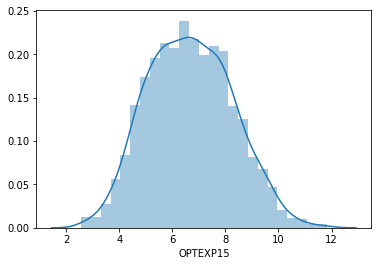

count      1961.000000
mean       2818.145334
std        7604.901311
min           3.000000
25%         230.000000
50%         736.000000
75%        2447.000000
max      134843.000000
Name: OPTEXP15, dtype: float64
----------------------------------
51
ARTHDX
OBVEXP15


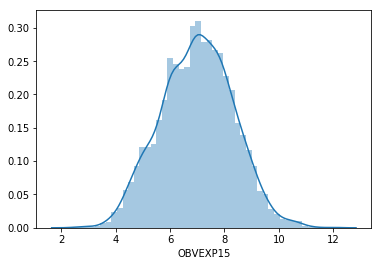

count      5680.000000
mean       2613.722535
std        5784.141261
min           1.000000
25%         421.750000
50%        1101.000000
75%        2739.000000
max      178468.000000
Name: OBVEXP15, dtype: float64
----------------------------------
52
ARTHDX
HHAEXP15


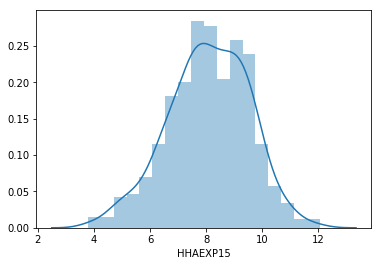

count       566.000000
mean       8076.745583
std       14576.718757
min          34.000000
25%        1298.500000
50%        3534.000000
75%        9488.250000
max      172690.000000
Name: HHAEXP15, dtype: float64
----------------------------------
53
ARTHDX
ERTEXP15


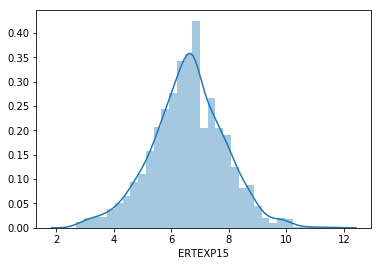

count      1473.000000
mean       1673.126273
std        4156.105029
min           5.000000
25%         324.000000
50%         741.000000
75%        1596.000000
max      104277.000000
Name: ERTEXP15, dtype: float64
----------------------------------
54
ARTHDX
IPTEXP15


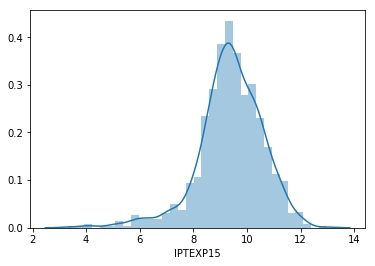

count       906.000000
mean      21866.246137
std       29483.166271
min          18.000000
25%        6415.750000
50%       12377.000000
75%       26559.750000
max      430298.000000
Name: IPTEXP15, dtype: float64
----------------------------------
55
ARTHDX
RXEXP15


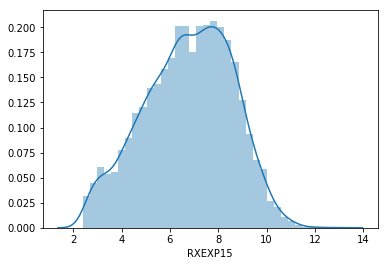

count      5674.000000
mean       3331.930208
std        9076.192665
min           1.000000
25%         224.000000
50%         956.000000
75%        3403.750000
max      414941.000000
Name: RXEXP15, dtype: float64
----------------------------------
56
ASTHDX
TOTEXP15


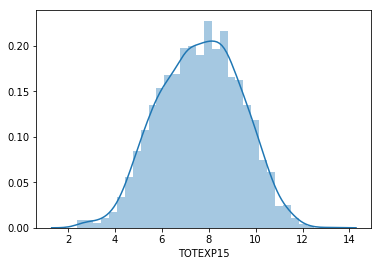

count      3143.000000
mean       7546.701559
std       17931.892908
min           1.000000
25%         569.000000
50%        2127.000000
75%        7115.000000
max      530792.000000
Name: TOTEXP15, dtype: float64
----------------------------------
57
ASTHDX
OPTEXP15


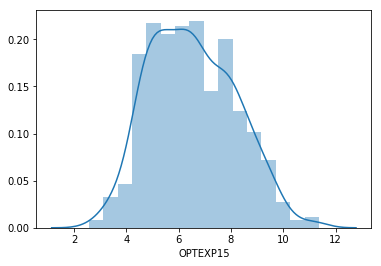

count      662.000000
mean      2664.070997
std       7229.006612
min          3.000000
25%        180.250000
50%        600.000000
75%       2360.000000
max      85911.000000
Name: OPTEXP15, dtype: float64
----------------------------------
58
ASTHDX
OBVEXP15


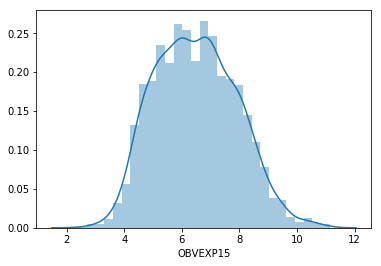

count     2735.000000
mean      1822.607678
std       4169.829418
min          1.000000
25%        208.500000
50%        610.000000
75%       1784.000000
max      68009.000000
Name: OBVEXP15, dtype: float64
----------------------------------
59
ASTHDX
HHAEXP15


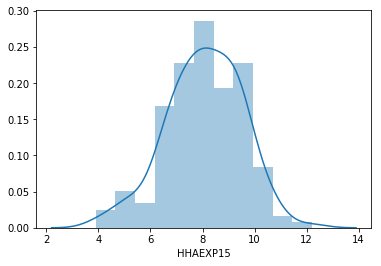

count       157.000000
mean       8355.789809
std       18413.400751
min          39.000000
25%        1163.000000
50%        3564.000000
75%        9804.000000
max      201150.000000
Name: HHAEXP15, dtype: float64
----------------------------------
60
ASTHDX
ERTEXP15


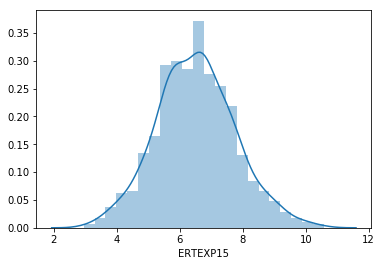

count      790.000000
mean      1522.732911
std       3030.114536
min          9.000000
25%        286.000000
50%        678.000000
75%       1507.250000
max      39471.000000
Name: ERTEXP15, dtype: float64
----------------------------------
61
ASTHDX
IPTEXP15


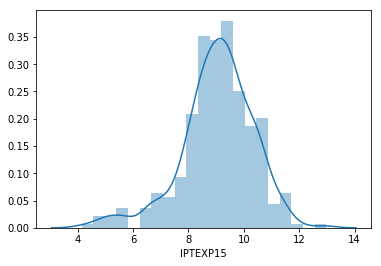

count       332.000000
mean      17495.921687
std       30839.353171
min          53.000000
25%        4484.000000
50%        9282.000000
75%       19336.000000
max      430298.000000
Name: IPTEXP15, dtype: float64
----------------------------------
62
ASTHDX
RXEXP15


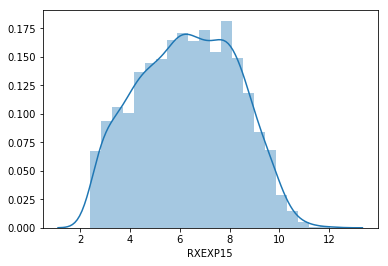

count      2658.000000
mean       2730.486080
std        6993.978741
min           1.000000
25%         110.000000
50%         571.000000
75%        2589.500000
max      171569.000000
Name: RXEXP15, dtype: float64
----------------------------------
63
ADHDADDX
TOTEXP15


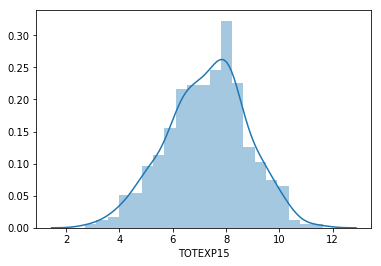

count       730.000000
mean       4047.328767
std        8190.232277
min           5.000000
25%         531.000000
50%        1612.500000
75%        3938.000000
max      111476.000000
Name: TOTEXP15, dtype: float64
----------------------------------
64
ADHDADDX
OPTEXP15


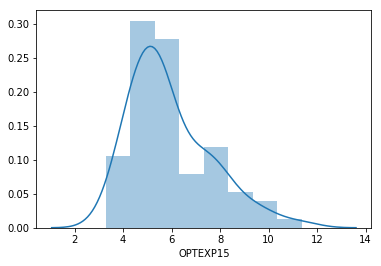

count       75.000000
mean      2672.640000
std      10563.373175
min         17.000000
25%         97.000000
50%        233.000000
75%       1116.000000
max      85911.000000
Name: OPTEXP15, dtype: float64
----------------------------------
65
ADHDADDX
OBVEXP15


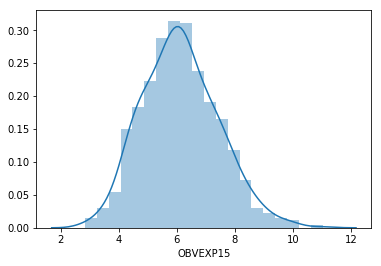

count      636.000000
mean      1209.545597
std       3347.353161
min          7.000000
25%        168.750000
50%        415.500000
75%       1061.500000
max      61928.000000
Name: OBVEXP15, dtype: float64
----------------------------------
66
ADHDADDX
HHAEXP15


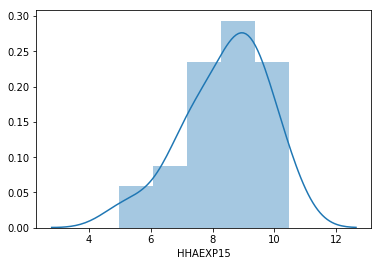

count       31.000000
mean      8670.548387
std       9239.412704
min        134.000000
25%       1745.500000
50%       6301.000000
75%      11243.000000
max      35184.000000
Name: HHAEXP15, dtype: float64
----------------------------------
67
ADHDADDX
ERTEXP15


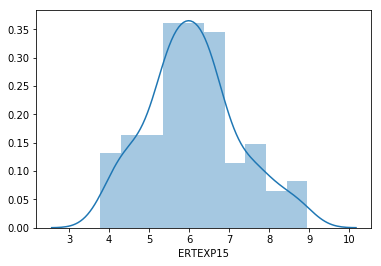

count     118.000000
mean      864.508475
std      1324.954795
min        34.000000
25%       208.000000
50%       398.000000
75%       826.500000
max      7693.000000
Name: ERTEXP15, dtype: float64
----------------------------------
68
ADHDADDX
IPTEXP15


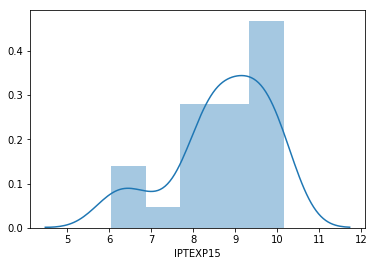

count       26.000000
mean      9522.269231
std       7800.545050
min        413.000000
25%       3717.500000
50%       6905.500000
75%      13262.000000
max      25870.000000
Name: IPTEXP15, dtype: float64
----------------------------------
69
ADHDADDX
RXEXP15


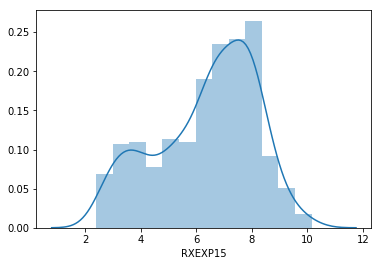

count      564.000000
mean      1809.177305
std       2916.104612
min          1.000000
25%        160.750000
50%        833.500000
75%       2366.750000
max      25642.000000
Name: RXEXP15, dtype: float64
----------------------------------
70
PREGNT31
TOTEXP15


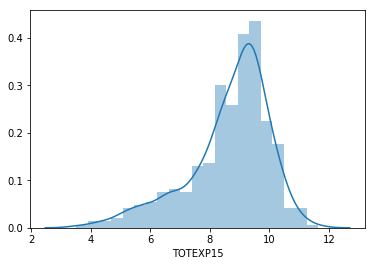

count       380.000000
mean      10816.586842
std       12055.271392
min          24.000000
25%        3200.000000
50%        8047.000000
75%       13767.000000
max      114262.000000
Name: TOTEXP15, dtype: float64
----------------------------------
71
PREGNT31
OPTEXP15


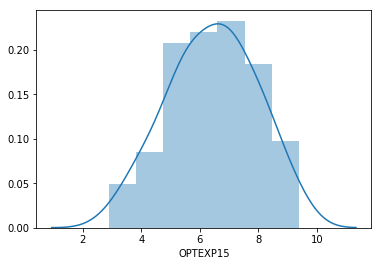

count       88.00000
mean      1605.75000
std       2450.15173
min          8.00000
25%        216.75000
50%        620.50000
75%       1919.00000
max      11867.00000
Name: OPTEXP15, dtype: float64
----------------------------------
72
PREGNT31
OBVEXP15


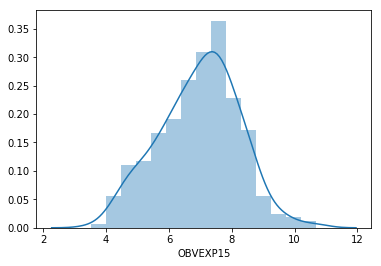

count      339.000000
mean      2268.365782
std       4189.201411
min         24.000000
25%        424.500000
50%       1184.000000
75%       2434.000000
max      44155.000000
Name: OBVEXP15, dtype: float64
----------------------------------
73
PREGNT31
HHAEXP15


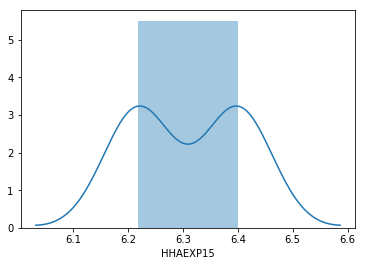

PREGNT31 obervation count smaller than 10
observation count smaller than 10
----------------------------------
74
PREGNT31
ERTEXP15


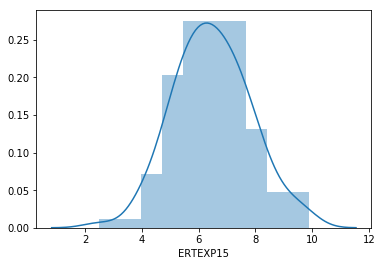

count      113.000000
mean      1600.646018
std       2966.442178
min          2.000000
25%        260.000000
50%        583.000000
75%       1737.000000
max      19418.000000
Name: ERTEXP15, dtype: float64
----------------------------------
75
PREGNT31
IPTEXP15


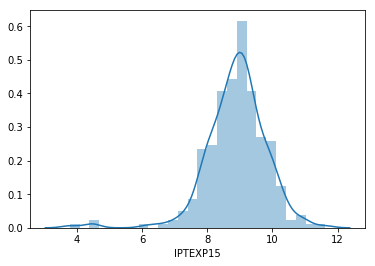

count       269.000000
mean      10579.918216
std       11132.914936
min          34.000000
25%        4514.000000
50%        7494.000000
75%       11971.000000
max      111309.000000
Name: IPTEXP15, dtype: float64
----------------------------------
76
PREGNT31
RXEXP15


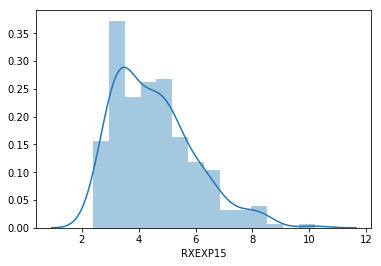

count      275.000000
mean       386.683636
std       1741.876754
min          1.000000
25%         20.500000
50%         62.000000
75%        203.500000
max      26507.000000
Name: RXEXP15, dtype: float64
----------------------------------
77
IADLHP31
TOTEXP15


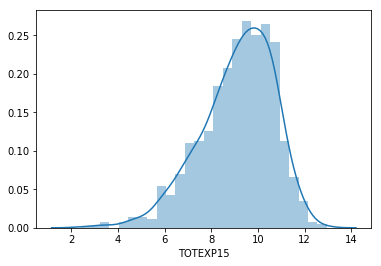

count      1052.000000
mean      22445.936312
std       32854.387304
min           1.000000
25%        3463.750000
50%       11281.000000
75%       29199.500000
max      423121.000000
Name: TOTEXP15, dtype: float64
----------------------------------
78
IADLHP31
OPTEXP15


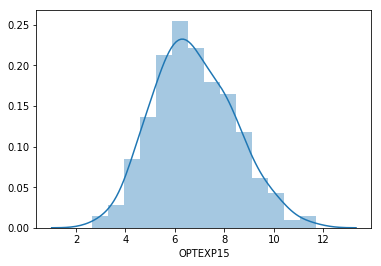

count       327.000000
mean       3528.155963
std        9950.472563
min           4.000000
25%         260.000000
50%         759.000000
75%        2660.500000
max      121690.000000
Name: OPTEXP15, dtype: float64
----------------------------------
79
IADLHP31
OBVEXP15


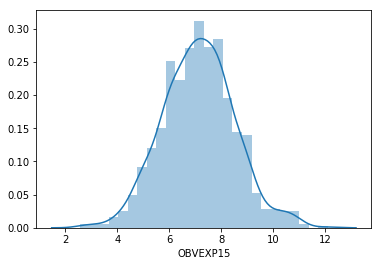

count       980.000000
mean       3483.918367
std        9126.258130
min           3.000000
25%         474.500000
50%        1225.000000
75%        3010.000000
max      178468.000000
Name: OBVEXP15, dtype: float64
----------------------------------
80
IADLHP31
HHAEXP15


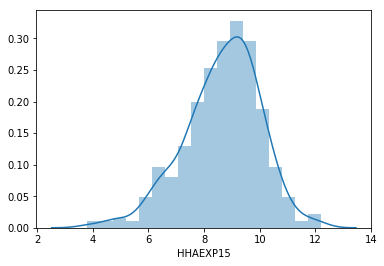

count       398.000000
mean      12559.095477
std       20625.584328
min          34.000000
25%        2406.750000
50%        6692.000000
75%       14282.000000
max      198046.000000
Name: HHAEXP15, dtype: float64
----------------------------------
81
IADLHP31
ERTEXP15


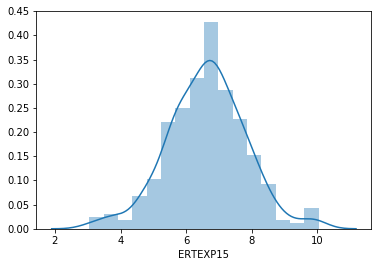

count      374.000000
mean      1554.050802
std       2873.757698
min         11.000000
25%        317.250000
50%        797.000000
75%       1592.000000
max      22870.000000
Name: ERTEXP15, dtype: float64
----------------------------------
82
IADLHP31
IPTEXP15


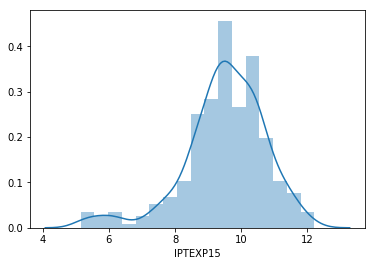

count       279.000000
mean      23949.523297
std       27696.956143
min         161.000000
25%        7240.500000
50%       14029.000000
75%       29195.500000
max      200774.000000
Name: IPTEXP15, dtype: float64
----------------------------------
83
IADLHP31
RXEXP15


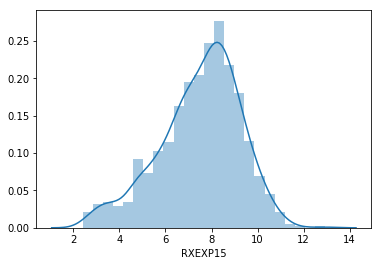

count       995.000000
mean       5895.928643
std       16233.589365
min           1.000000
25%         622.500000
50%        2350.000000
75%        6066.000000
max      414941.000000
Name: RXEXP15, dtype: float64


In [11]:
#emphdx hhaexp
#
out_dic_summary ={}
n=0
for d in disease_f:
    out_dic_summary[d] = {}
    for e in exp_l:
        print("----------------------------------")
        print(n)
        print(d)
        print(e)
        n+=1
        
        try :
            out_dic_summary[d][e] = summary_y(d,e,df_c,df)
            print(out_dic_summary[d][e])
        except:
            out_dic[d][e] = "NaN"
outt_df_summary = pd.DataFrame(out_dic_summary)
outt_df_summary = outt_df_summary.transpose()
outt_df_summary.to_excel("MEPS_Disease_Expenditure_stats_summary_7.12.xlsx")

----------------------------------
0
CANCERDX
TOTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   38.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


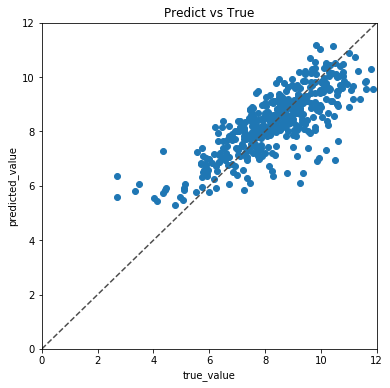

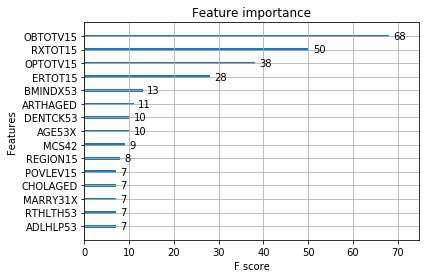

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 65}
{'test R^2': 0.6286985284841843, 'observations_count': 2170}
----------------------------------
1
CANCERDX
OPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   32.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


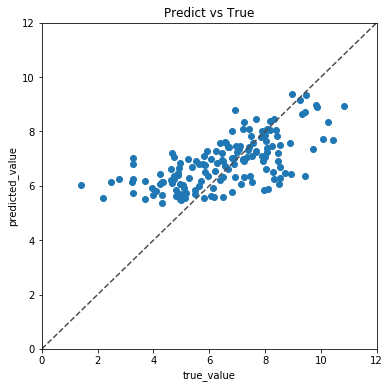

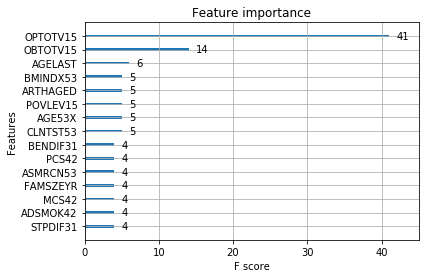

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.3383718065347896, 'observations_count': 752}
----------------------------------
2
CANCERDX
OBVEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   35.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


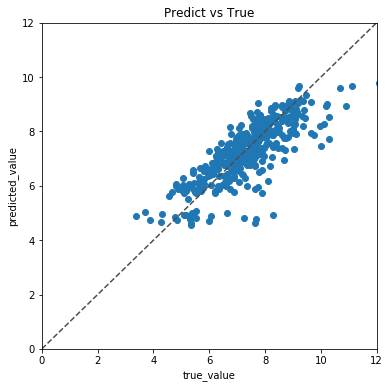

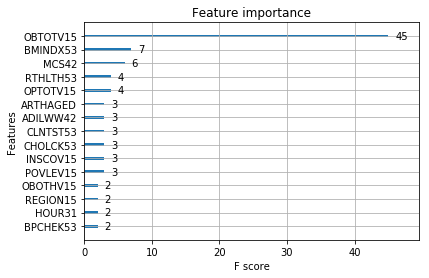

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.7063719145060977, 'observations_count': 2042}
----------------------------------
3
CANCERDX
HHAEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   20.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


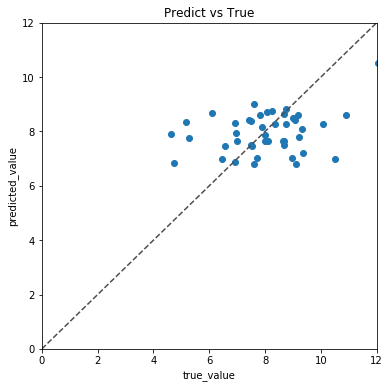

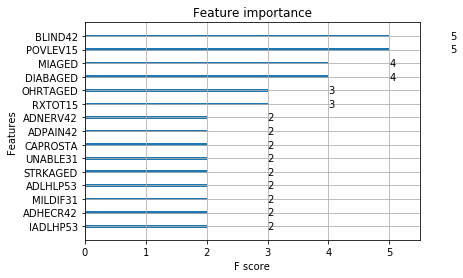

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25}
{'test R^2': -0.020128457592152375, 'observations_count': 220}
----------------------------------
4
CANCERDX
ERTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   23.2s finished


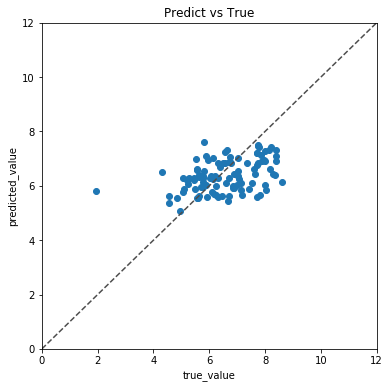

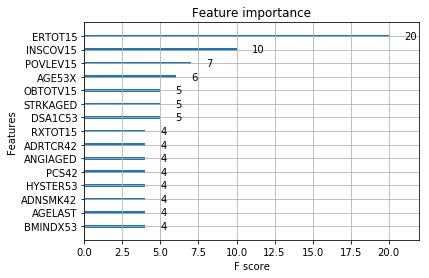

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.14755894597245967, 'observations_count': 518}
----------------------------------
5
CANCERDX
IPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   20.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


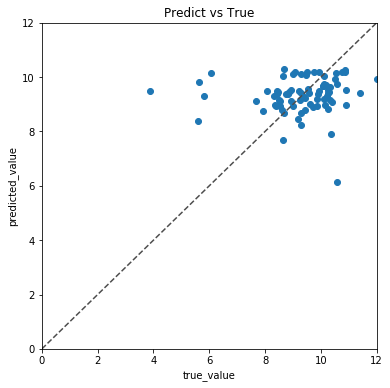

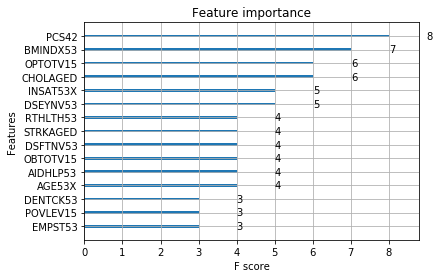

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.05285048065057457, 'observations_count': 393}
----------------------------------
6
CANCERDX
RXEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   30.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


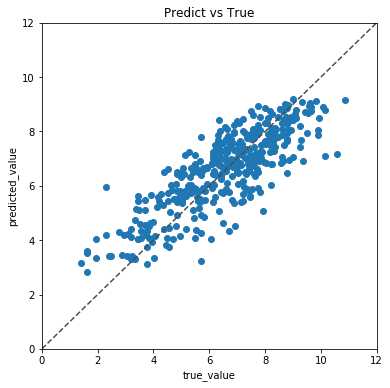

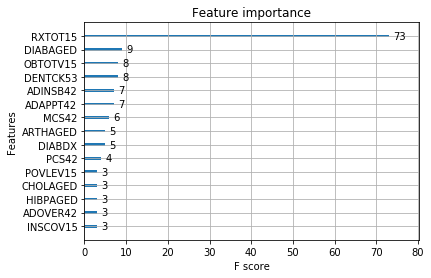

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.6473263203611558, 'observations_count': 2013}
----------------------------------
7
CHDDX
TOTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   27.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


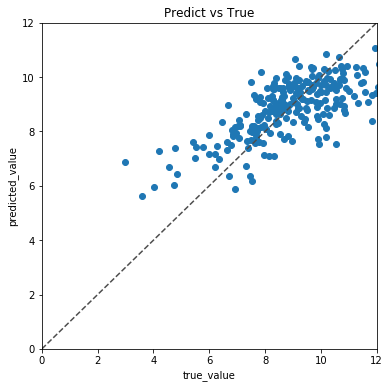

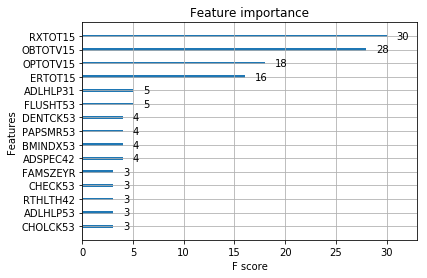

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.5360417406505904, 'observations_count': 1256}
----------------------------------
8
CHDDX
OPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   20.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


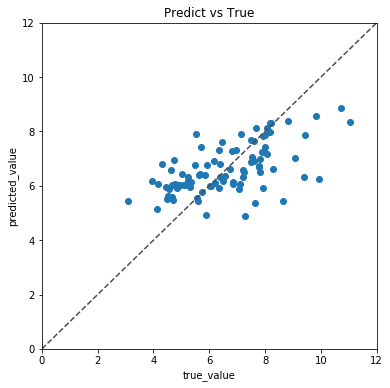

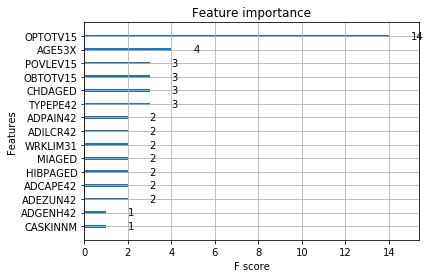

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25}
{'test R^2': 0.1896683581757754, 'observations_count': 453}
----------------------------------
9
CHDDX
OBVEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   30.6s finished


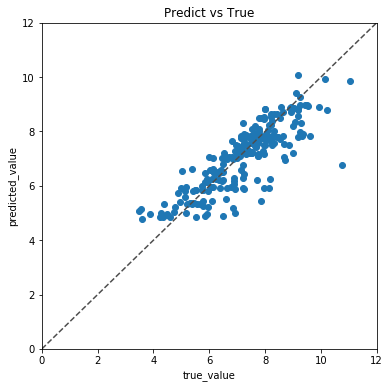

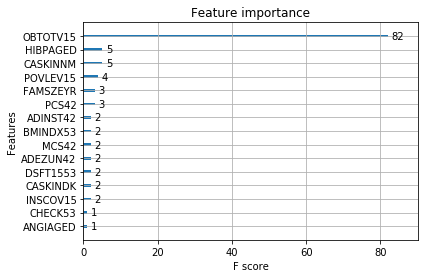

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.7227387346499604, 'observations_count': 1171}
----------------------------------
10
CHDDX
HHAEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   17.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


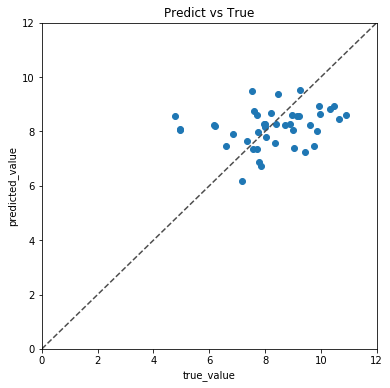

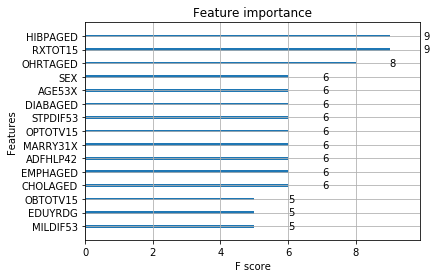

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 45}
{'test R^2': 0.09459193934095644, 'observations_count': 215}
----------------------------------
11
CHDDX
ERTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   19.6s finished


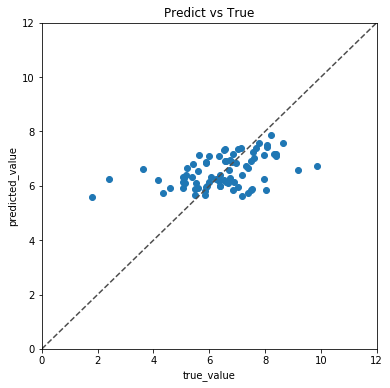

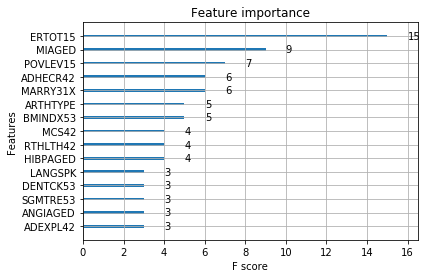

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.052606537108156805, 'observations_count': 398}
----------------------------------
12
CHDDX
IPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   20.3s finished


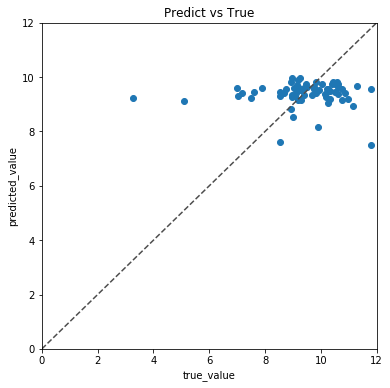

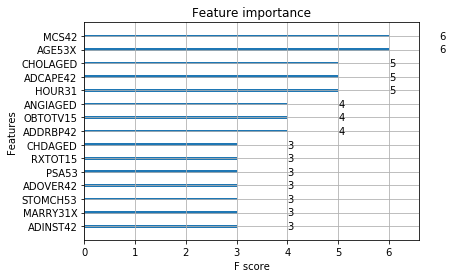

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': -0.12008597168092905, 'observations_count': 334}
----------------------------------
13
CHDDX
RXEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   24.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


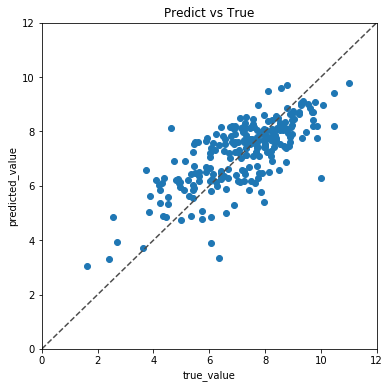

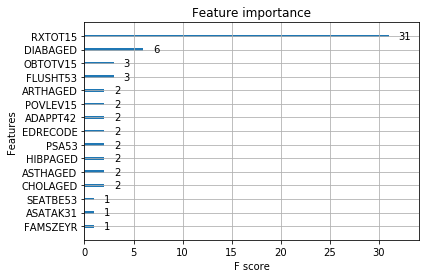

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25}
{'test R^2': 0.6221564075688459, 'observations_count': 1209}
----------------------------------
14
STRKDX
TOTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   26.4s finished


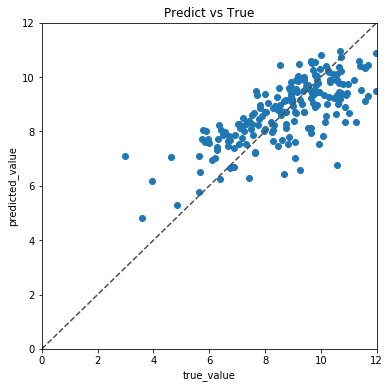

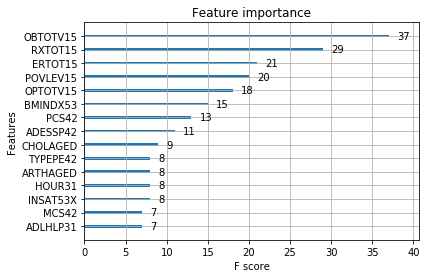

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 65}
{'test R^2': 0.5138954539041255, 'observations_count': 1013}
----------------------------------
15
STRKDX
OPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   20.1s finished


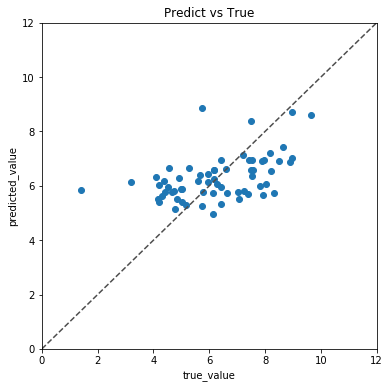

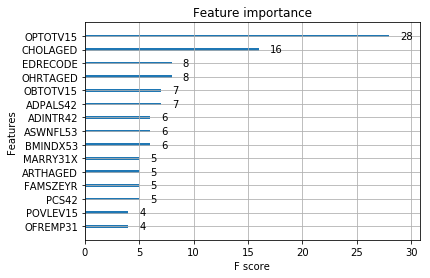

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.2731498828417156, 'observations_count': 316}
----------------------------------
16
STRKDX
OBVEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   32.5s finished


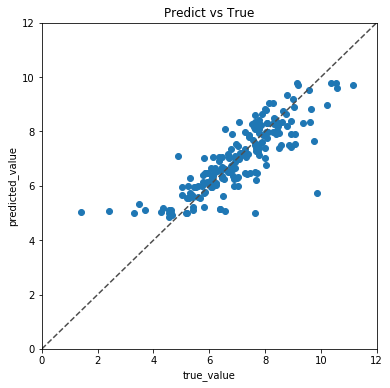

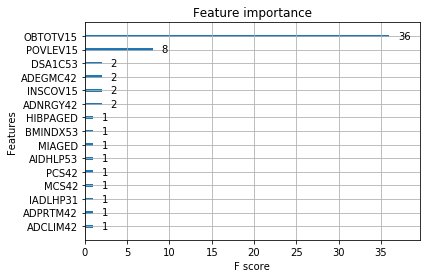

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25}
{'test R^2': 0.7116788879953767, 'observations_count': 934}
----------------------------------
17
STRKDX
HHAEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  74 out of  81 | elapsed:   19.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   20.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


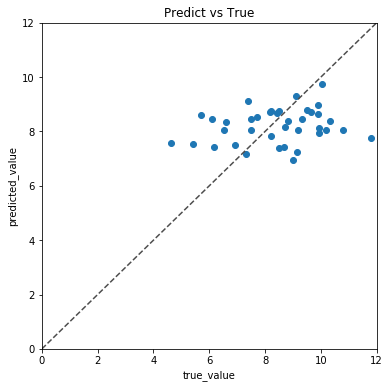

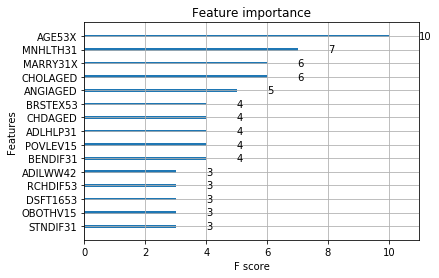

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.02460500511849435, 'observations_count': 190}
----------------------------------
18
STRKDX
ERTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   20.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


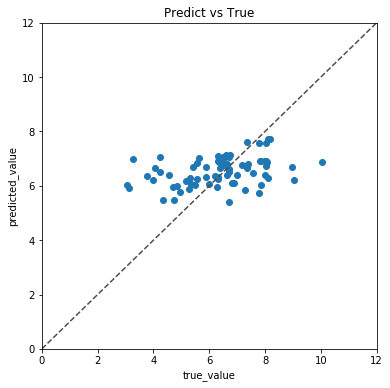

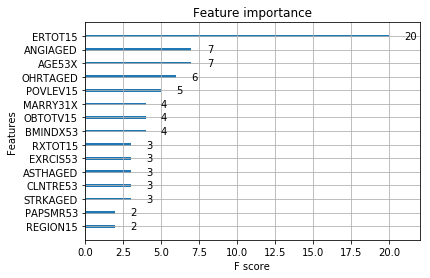

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.045730065081323844, 'observations_count': 365}
----------------------------------
19
STRKDX
IPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  74 out of  81 | elapsed:   19.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   19.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


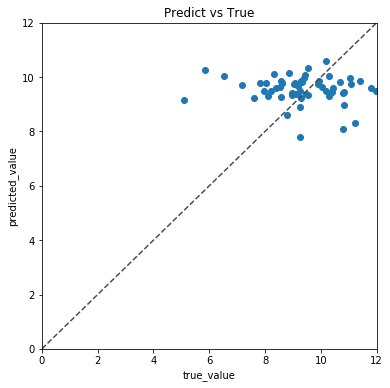

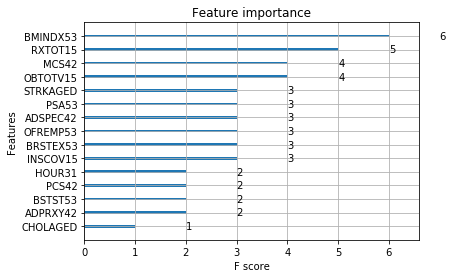

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25}
{'test R^2': -0.06049915194039986, 'observations_count': 283}
----------------------------------
20
STRKDX
RXEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   21.4s finished


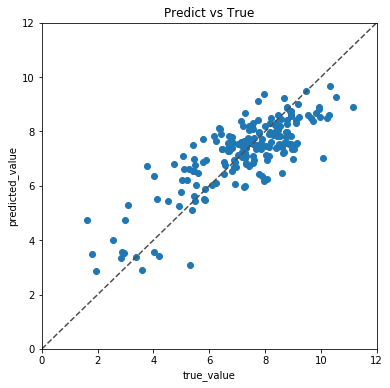

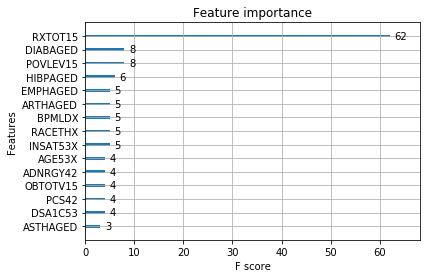

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.5459588294438087, 'observations_count': 964}
----------------------------------
21
OHRTDX
TOTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   30.2s finished


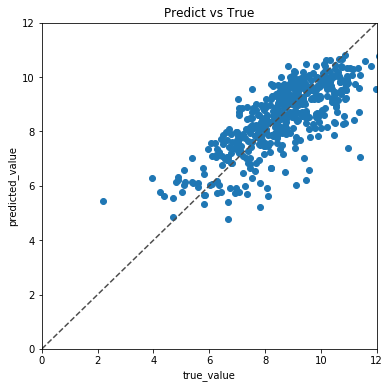

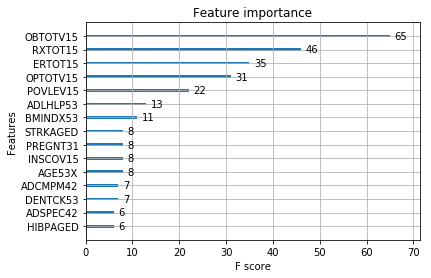

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 65}
{'test R^2': 0.6226687814460312, 'observations_count': 2370}
----------------------------------
22
OHRTDX
OPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   20.6s finished


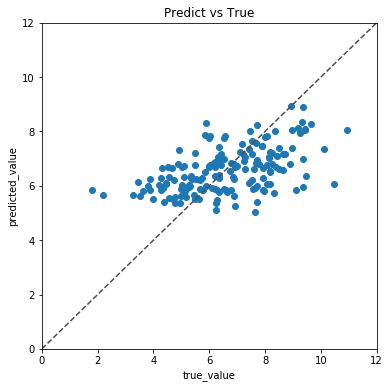

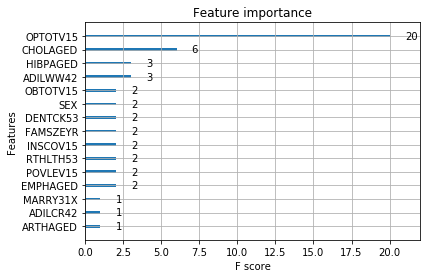

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25}
{'test R^2': 0.2592469030380532, 'observations_count': 837}
----------------------------------
23
OHRTDX
OBVEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   29.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


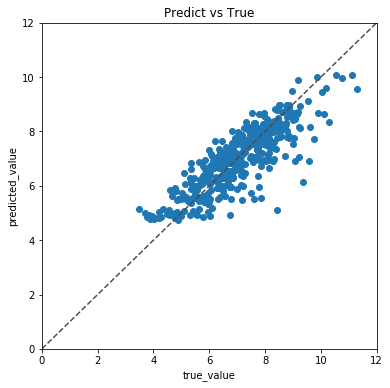

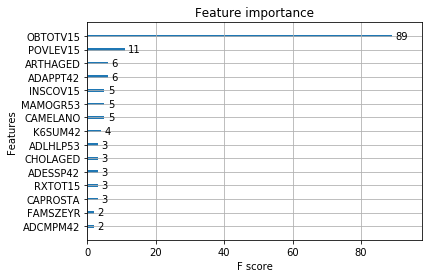

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.7022967995308363, 'observations_count': 2199}
----------------------------------
24
OHRTDX
HHAEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   18.0s finished


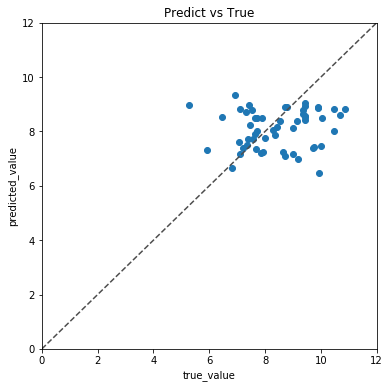

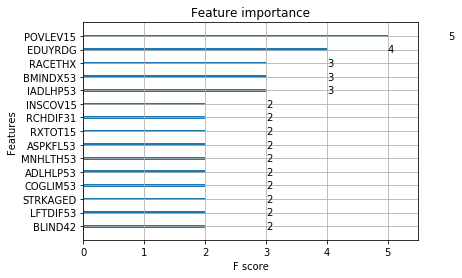

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25}
{'test R^2': -0.10659922875003598, 'observations_count': 271}
----------------------------------
25
OHRTDX
ERTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   19.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


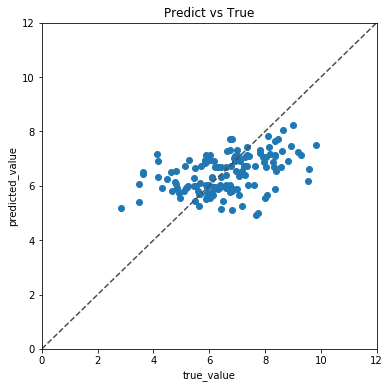

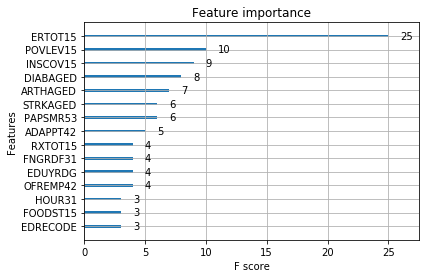

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.21376003067320645, 'observations_count': 695}
----------------------------------
26
OHRTDX
IPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   19.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


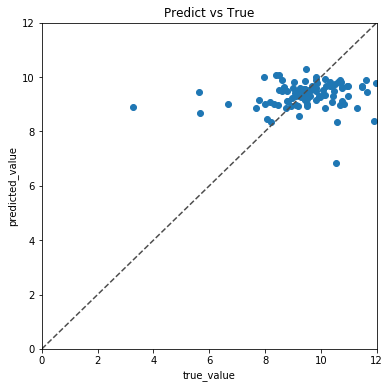

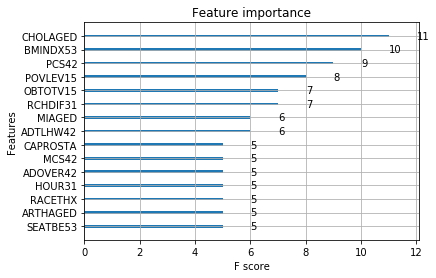

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': -0.12591330404026868, 'observations_count': 483}
----------------------------------
27
OHRTDX
RXEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   27.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


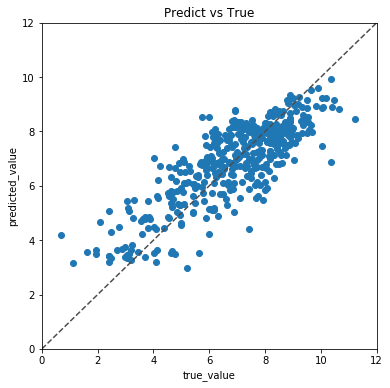

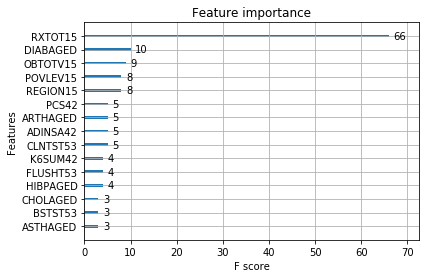

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.653824134572093, 'observations_count': 2192}
----------------------------------
28
HIBPDX
TOTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.0min finished


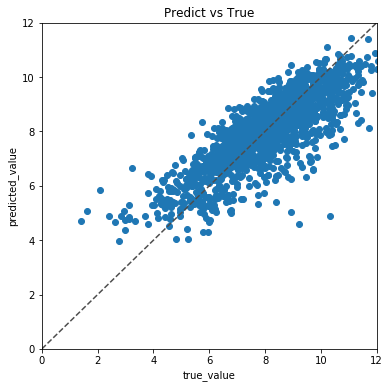

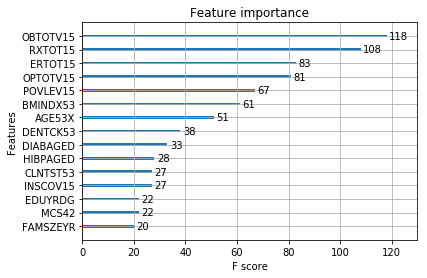

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 65}
{'test R^2': 0.6475766947608681, 'observations_count': 7890}
----------------------------------
29
HIBPDX
OPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   37.2s finished


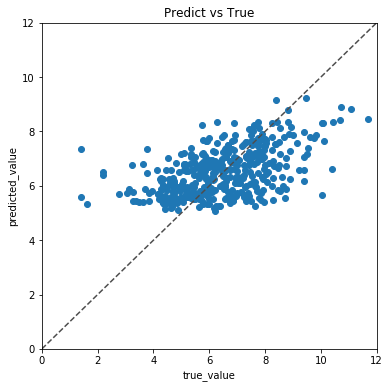

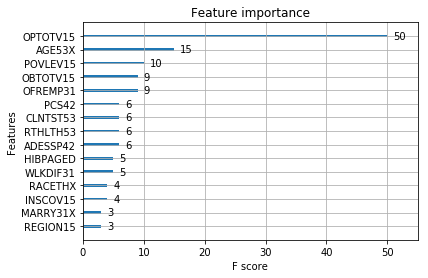

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.32744456269473565, 'observations_count': 2055}
----------------------------------
30
HIBPDX
OBVEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.1min finished


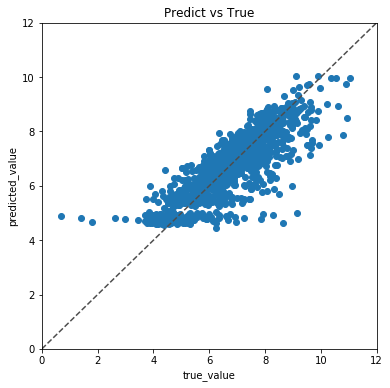

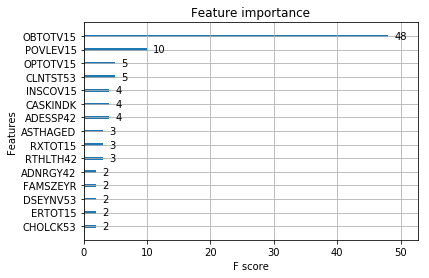

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.7308902372648475, 'observations_count': 7125}
----------------------------------
31
HIBPDX
HHAEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   26.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


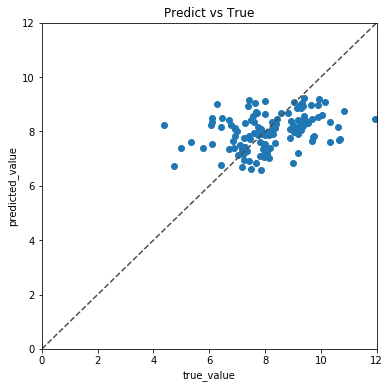

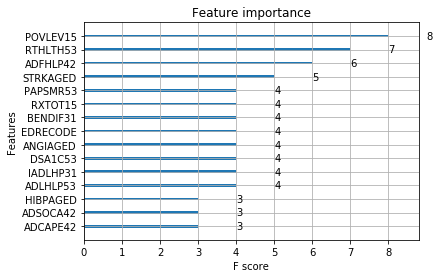

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.1820695087125828, 'observations_count': 629}
----------------------------------
32
HIBPDX
ERTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   37.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


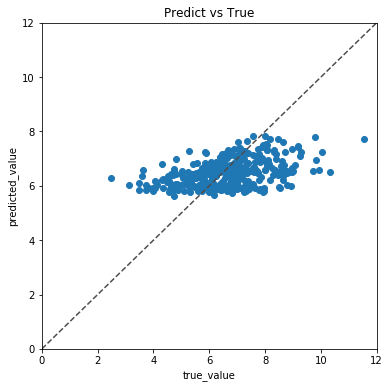

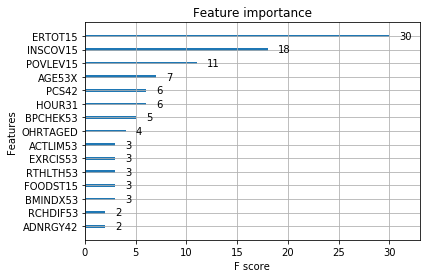

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.17038827902805267, 'observations_count': 1734}
----------------------------------
33
HIBPDX
IPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   34.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


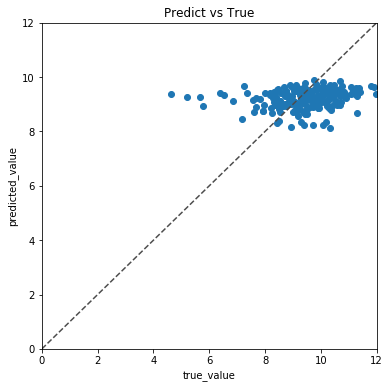

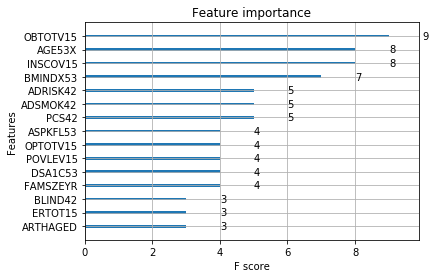

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.04513485749114331, 'observations_count': 1087}
----------------------------------
34
HIBPDX
RXEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


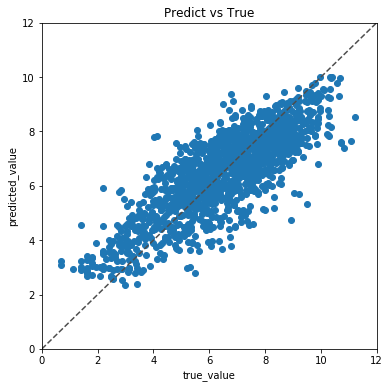

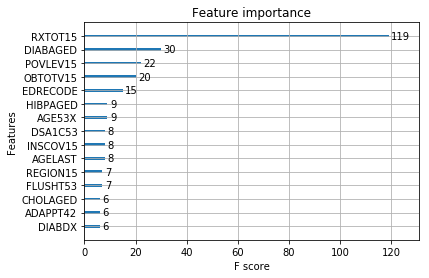

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 65}
{'test R^2': 0.6568145365830241, 'observations_count': 7349}
----------------------------------
35
EMPHDX
TOTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   22.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


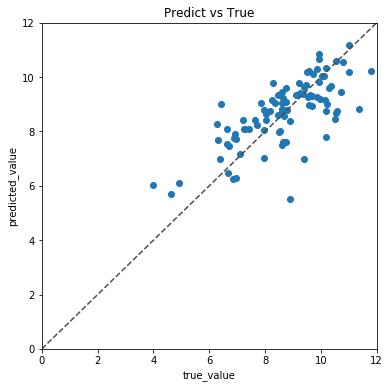

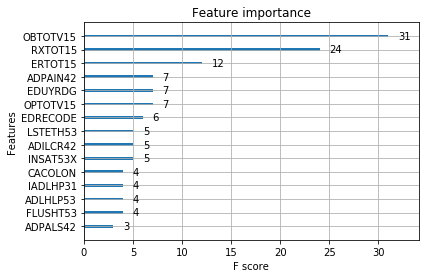

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.5773840634886428, 'observations_count': 452}
----------------------------------
36
EMPHDX
OPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  74 out of  81 | elapsed:   20.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   21.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


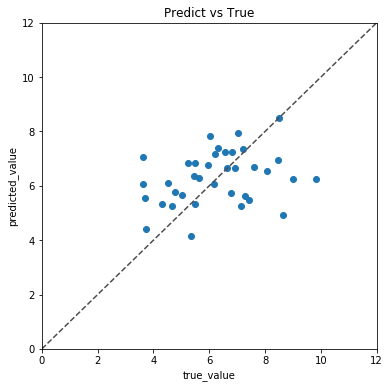

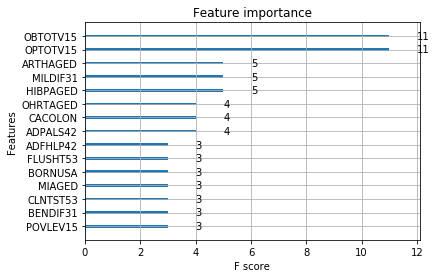

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 25}
{'test R^2': 0.03250125924900528, 'observations_count': 183}
----------------------------------
37
EMPHDX
OBVEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   22.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


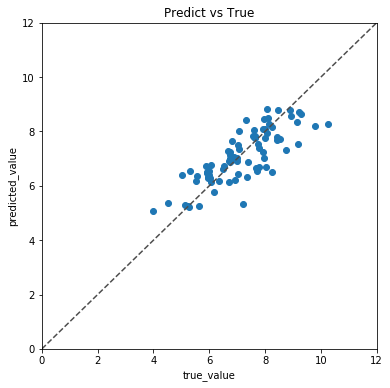

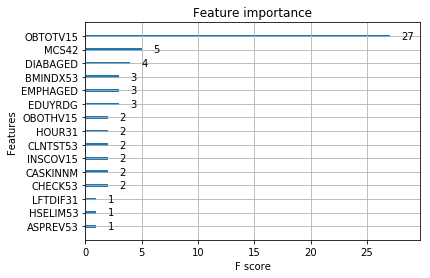

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25}
{'test R^2': 0.6981488806773553, 'observations_count': 415}
----------------------------------
38
EMPHDX
HHAEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   19.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


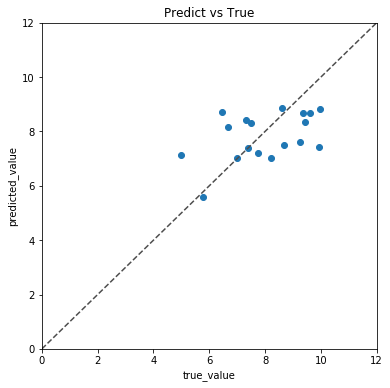

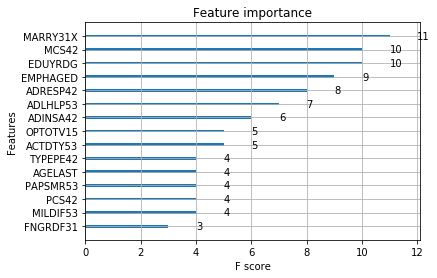

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': -0.051425702670195875, 'observations_count': 86}
----------------------------------
39
EMPHDX
ERTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   18.4s finished


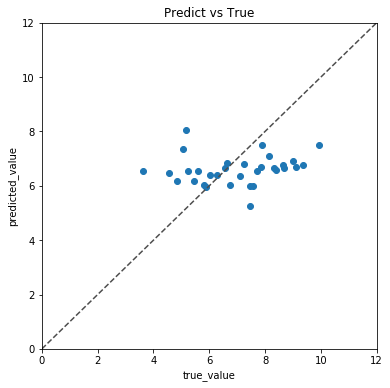

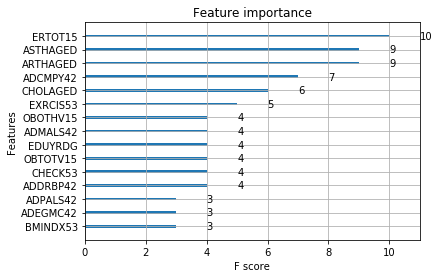

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.0033641775920118335, 'observations_count': 158}
----------------------------------
40
EMPHDX
IPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  74 out of  81 | elapsed:   17.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   17.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


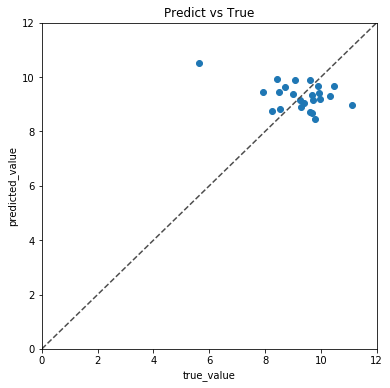

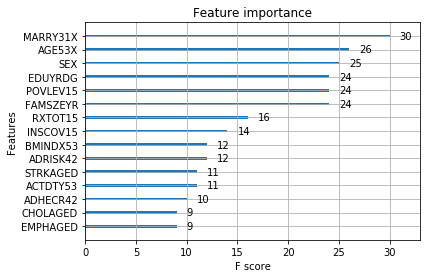

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 45}
{'test R^2': -0.2883481071827206, 'observations_count': 116}
----------------------------------
41
EMPHDX
RXEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   19.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


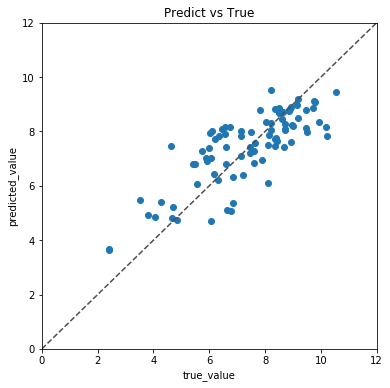

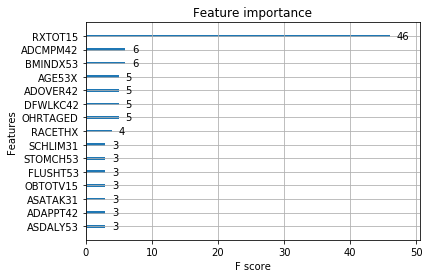

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.5387525496981884, 'observations_count': 438}
----------------------------------
42
DIABDX
TOTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   38.0s finished


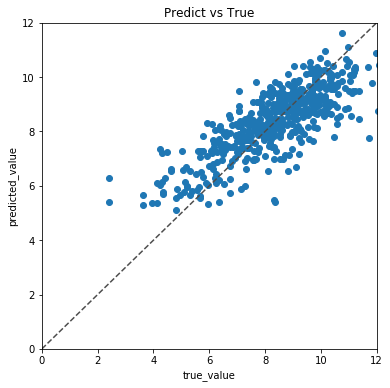

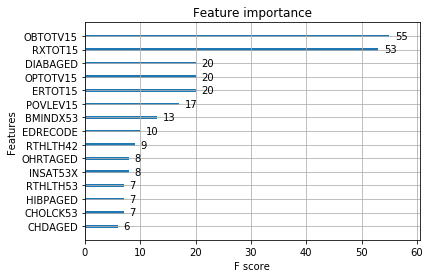

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 65}
{'test R^2': 0.6071696018027921, 'observations_count': 2715}
----------------------------------
43
DIABDX
OPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   28.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


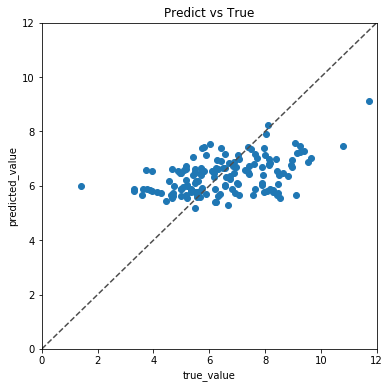

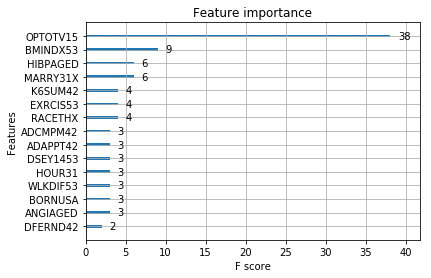

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.19517234922617485, 'observations_count': 753}
----------------------------------
44
DIABDX
OBVEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   36.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


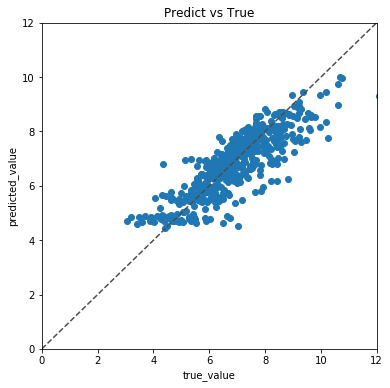

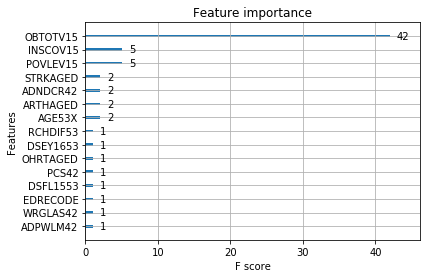

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25}
{'test R^2': 0.7480884436078545, 'observations_count': 2510}
----------------------------------
45
DIABDX
HHAEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   20.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


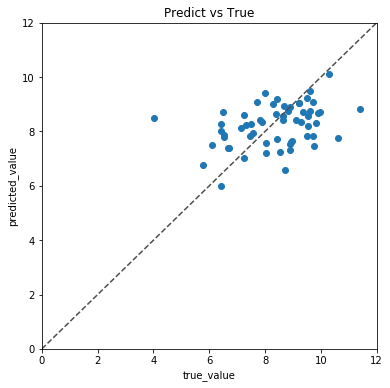

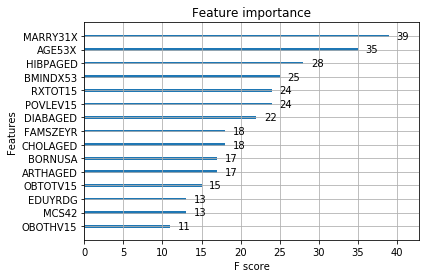

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 45}
{'test R^2': -0.03896412586810015, 'observations_count': 291}
----------------------------------
46
DIABDX
ERTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   25.4s finished


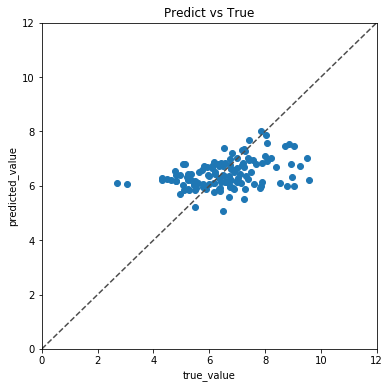

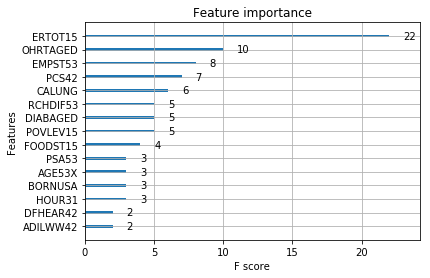

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.08882232195807088, 'observations_count': 627}
----------------------------------
47
DIABDX
IPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   30.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


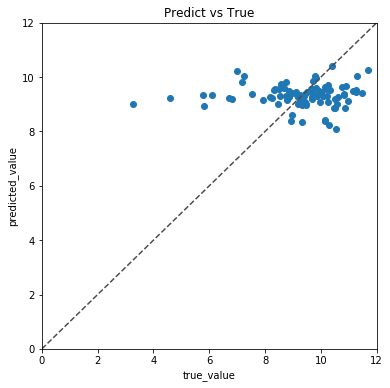

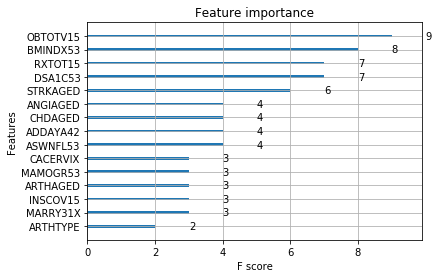

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': -0.06386347782503794, 'observations_count': 444}
----------------------------------
48
DIABDX
RXEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   42.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


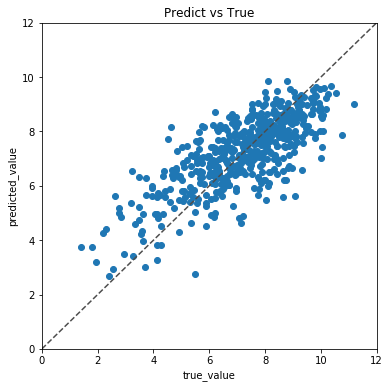

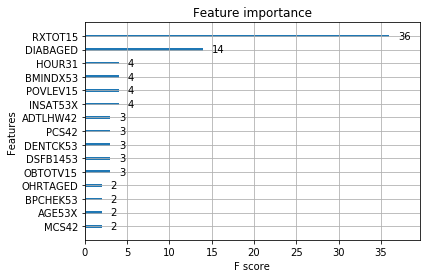

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.5722083760468746, 'observations_count': 2635}
----------------------------------
49
ARTHDX
TOTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   54.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


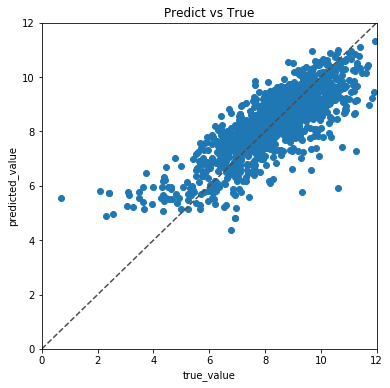

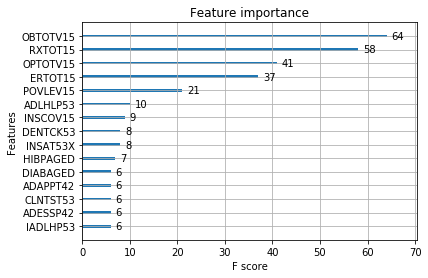

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 65}
{'test R^2': 0.6327692365464965, 'observations_count': 6066}
----------------------------------
50
ARTHDX
OPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   33.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


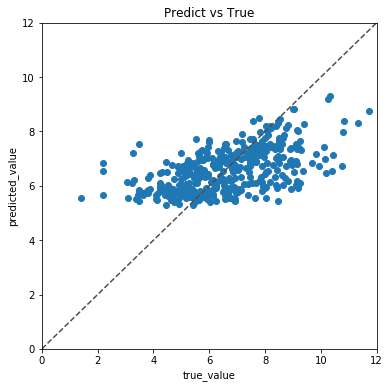

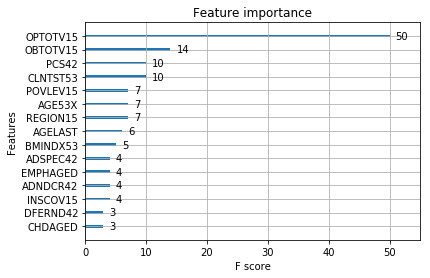

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.2934046889000846, 'observations_count': 1961}
----------------------------------
51
ARTHDX
OBVEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   57.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


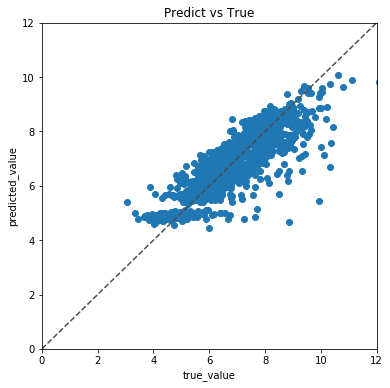

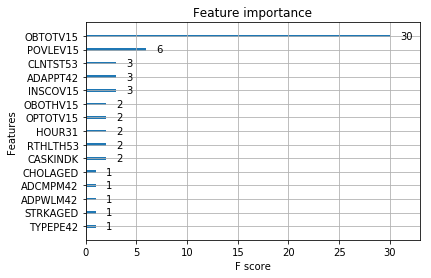

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 25}
{'test R^2': 0.7301739638008115, 'observations_count': 5680}
----------------------------------
52
ARTHDX
HHAEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   35.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


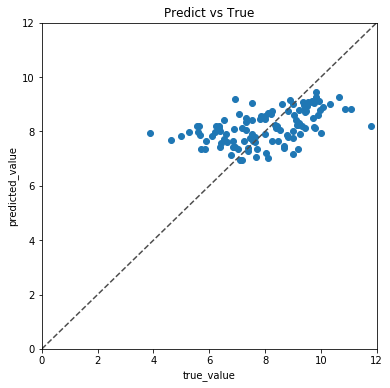

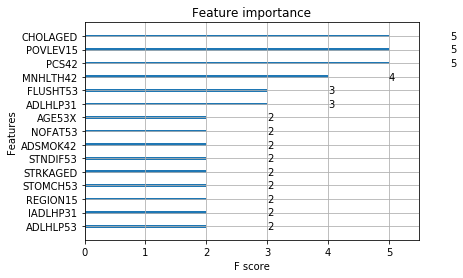

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25}
{'test R^2': 0.10258999584097604, 'observations_count': 566}
----------------------------------
53
ARTHDX
ERTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   29.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


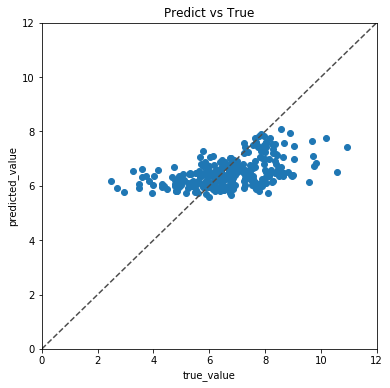

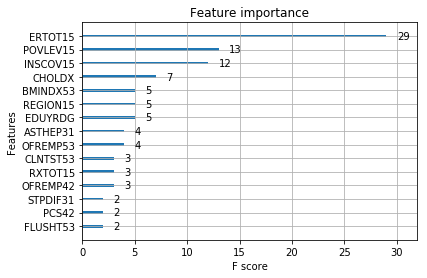

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.15314662245698937, 'observations_count': 1473}
----------------------------------
54
ARTHDX
IPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   24.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


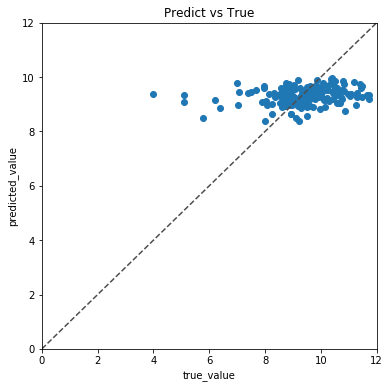

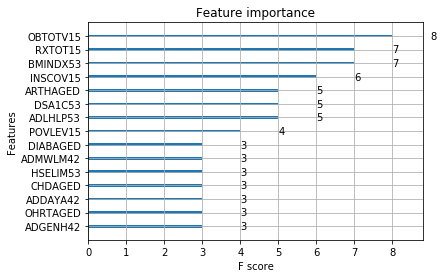

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.029579485557979804, 'observations_count': 906}
----------------------------------
55
ARTHDX
RXEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   55.9s finished


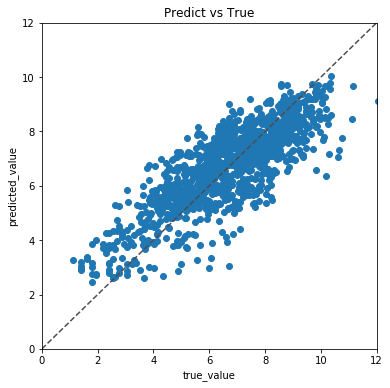

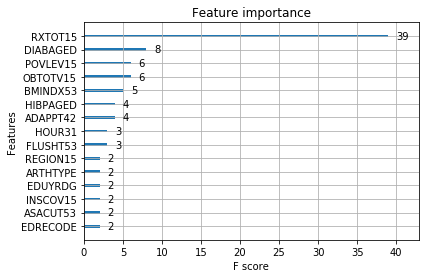

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.6533915025585435, 'observations_count': 5674}
----------------------------------
56
ASTHDX
TOTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   38.6s finished


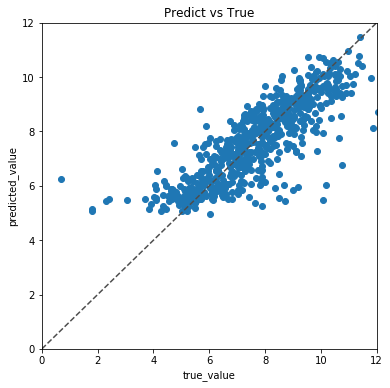

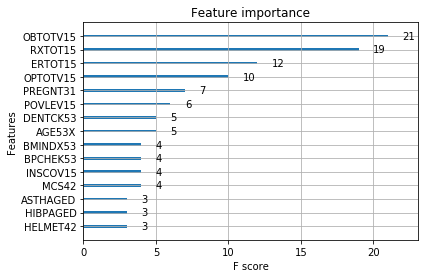

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.6798876994528665, 'observations_count': 3143}
----------------------------------
57
ASTHDX
OPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   23.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


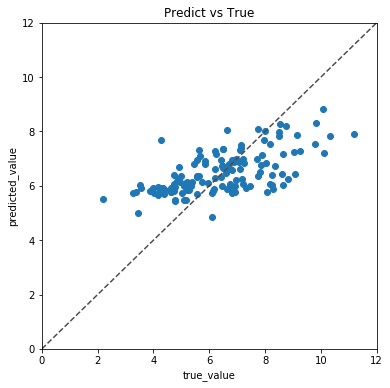

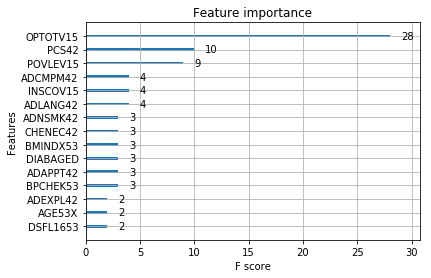

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.18892823598309935, 'observations_count': 662}
----------------------------------
58
ASTHDX
OBVEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   36.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


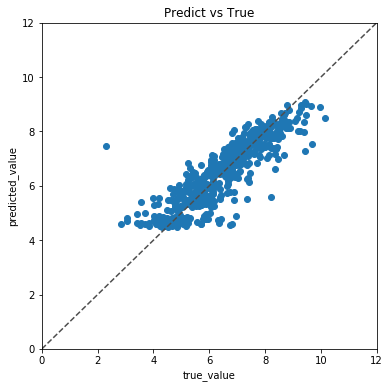

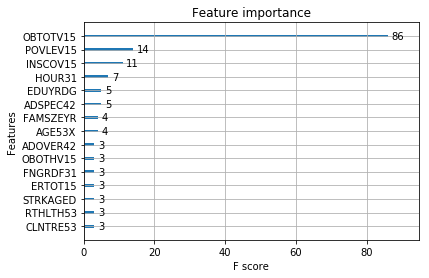

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.744791607213207, 'observations_count': 2735}
----------------------------------
59
ASTHDX
HHAEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   22.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


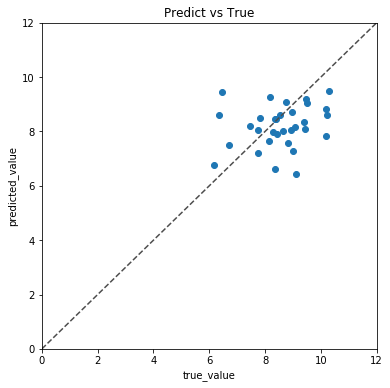

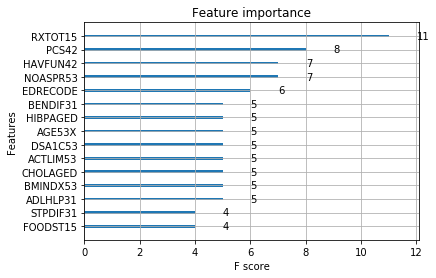

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': -0.05110822652670419, 'observations_count': 157}
----------------------------------
60
ASTHDX
ERTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   24.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


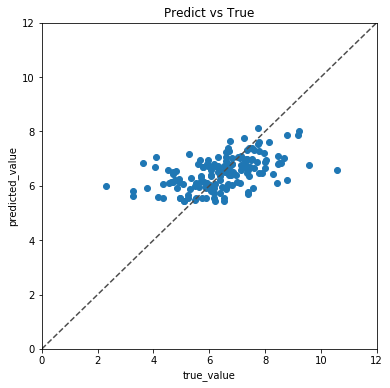

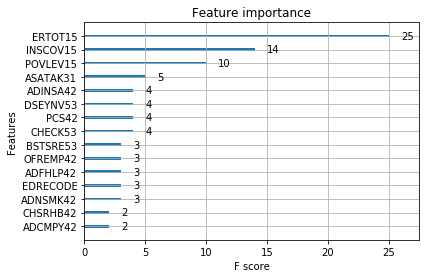

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.24586506944598147, 'observations_count': 790}
----------------------------------
61
ASTHDX
IPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   20.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


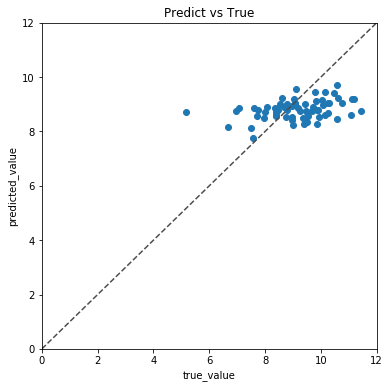

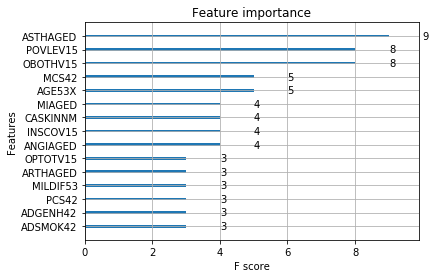

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': -0.151960226274786, 'observations_count': 332}
----------------------------------
62
ASTHDX
RXEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   37.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


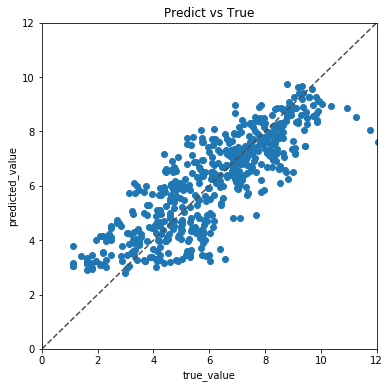

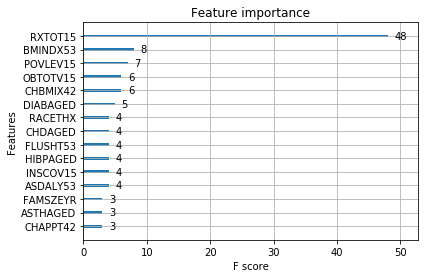

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.7307803314062442, 'observations_count': 2658}
----------------------------------
63
ADHDADDX
TOTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   21.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


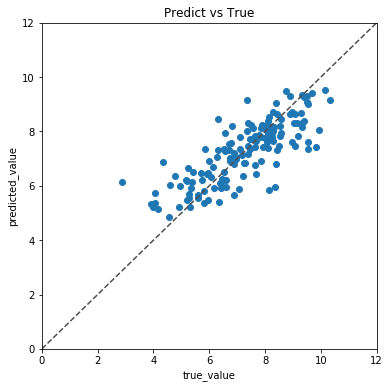

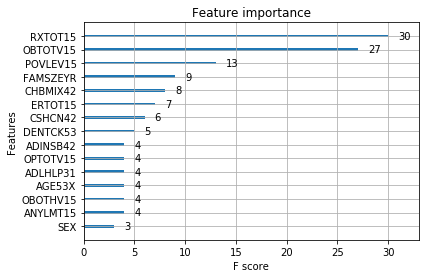

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.6330096444684841, 'observations_count': 730}
----------------------------------
64
ADHDADDX
OPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  74 out of  81 | elapsed:   19.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   19.4s finished


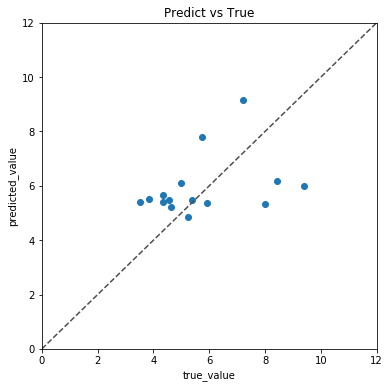

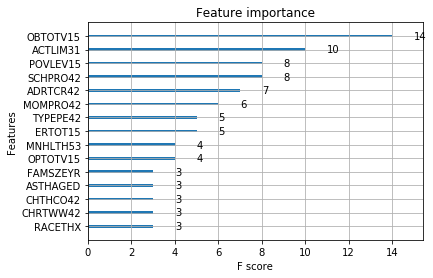

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': -0.08747159062936571, 'observations_count': 75}
----------------------------------
65
ADHDADDX
OBVEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   22.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


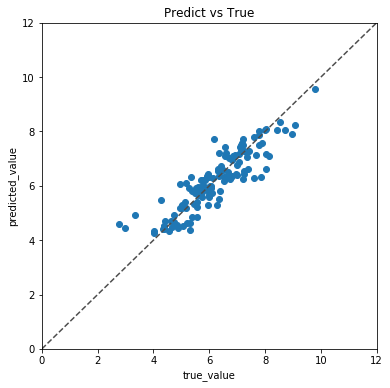

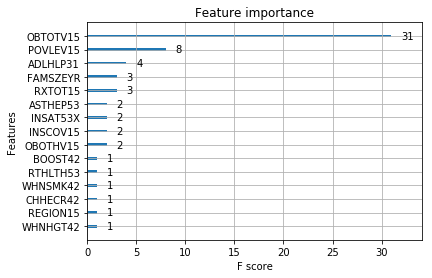

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25}
{'test R^2': 0.7578045118312053, 'observations_count': 636}
----------------------------------
66
ADHDADDX
HHAEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   17.1s finished


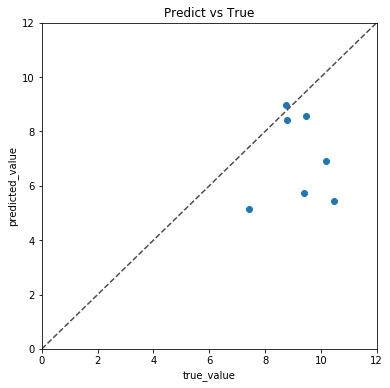

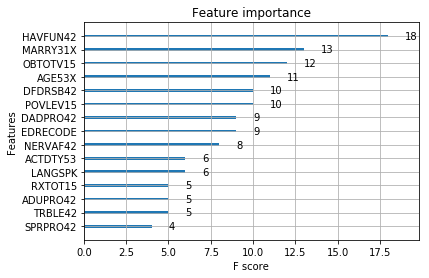

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 45}
{'test R^2': -1.7133391151223654, 'observations_count': 31}
----------------------------------
67
ADHDADDX
ERTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   18.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


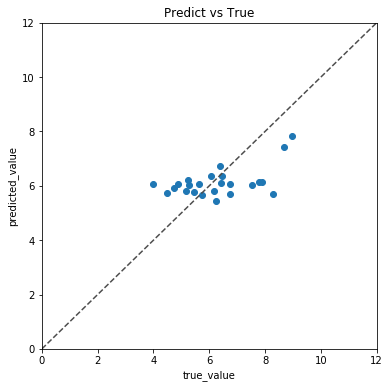

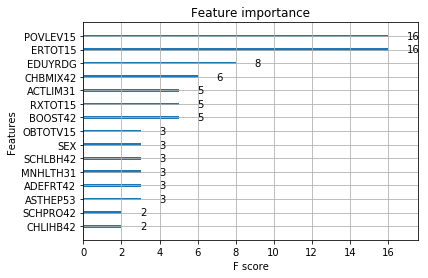

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': -0.16494710089924713, 'observations_count': 118}
----------------------------------
68
ADHDADDX
IPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   17.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


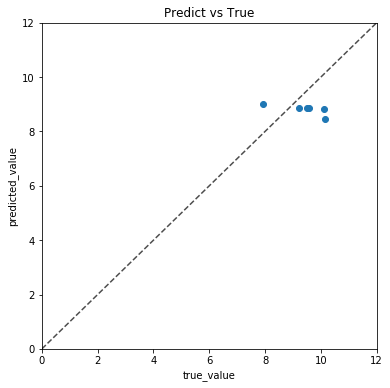

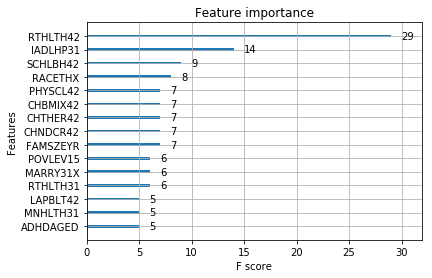

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 65}
{'test R^2': -1.913128344789796, 'observations_count': 26}
----------------------------------
69
ADHDADDX
RXEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   21.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


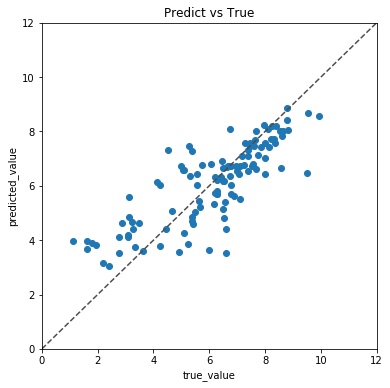

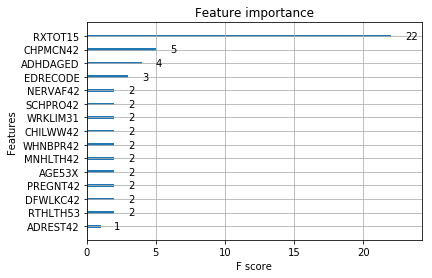

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25}
{'test R^2': 0.623441656134367, 'observations_count': 564}
----------------------------------
70
PREGNT31
TOTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   21.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


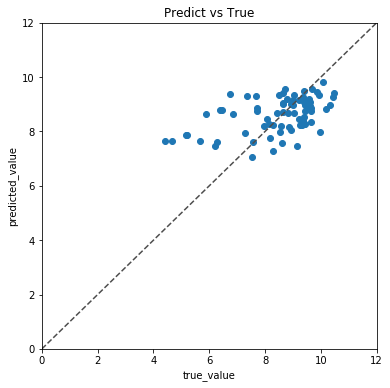

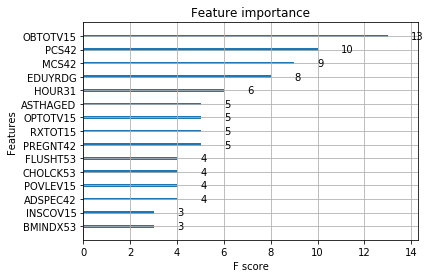

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.19070000324655695, 'observations_count': 380}
----------------------------------
71
PREGNT31
OPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  74 out of  81 | elapsed:   17.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   17.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


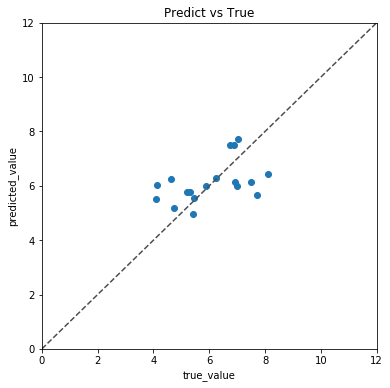

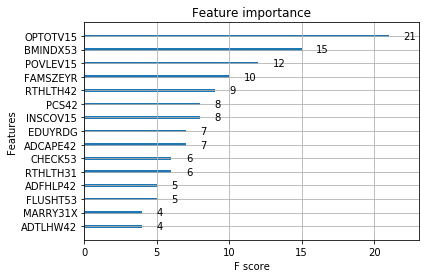

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.14946107830462685, 'observations_count': 88}
----------------------------------
72
PREGNT31
OBVEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   19.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


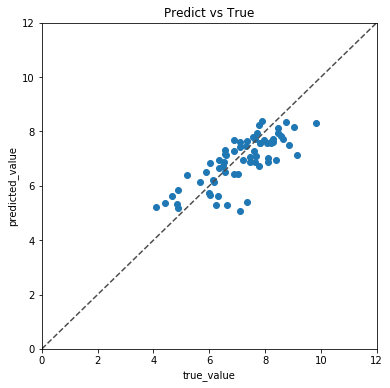

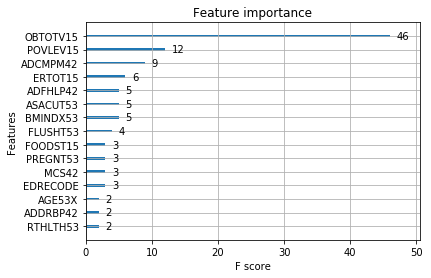

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.5287573661487349, 'observations_count': 339}
----------------------------------
73
PREGNT31
HHAEXP15
PREGNT31 obervation count smaller than 10
observation count smaller than 10
----------------------------------
74
PREGNT31
ERTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   20.3s finished


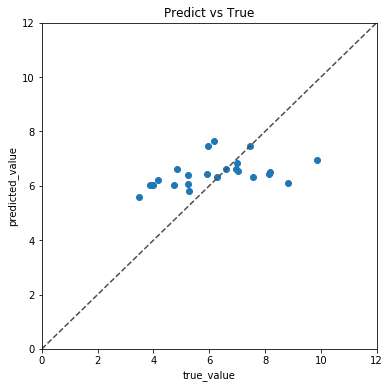

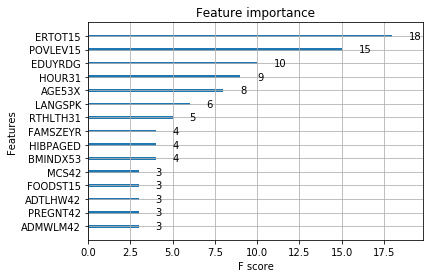

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': -0.13772510936740923, 'observations_count': 113}
----------------------------------
75
PREGNT31
IPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   18.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


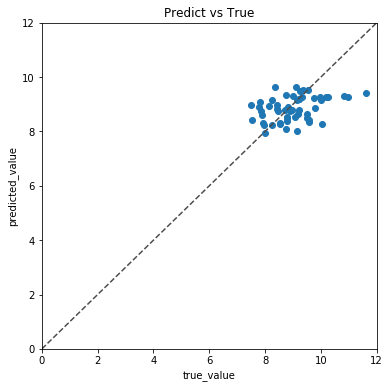

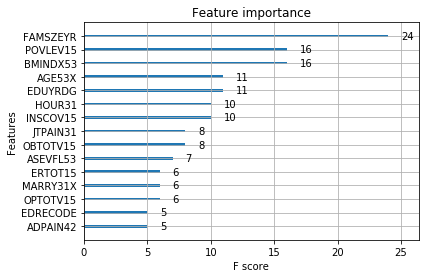

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 45}
{'test R^2': -0.07436202936019726, 'observations_count': 269}
----------------------------------
76
PREGNT31
RXEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   19.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


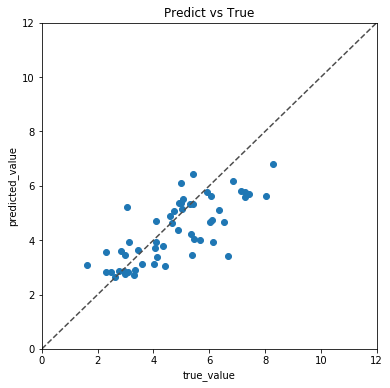

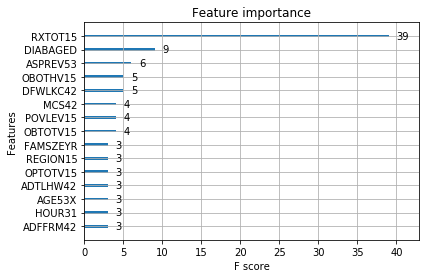

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.41493378484885285, 'observations_count': 275}
----------------------------------
77
IADLHP31
TOTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   28.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


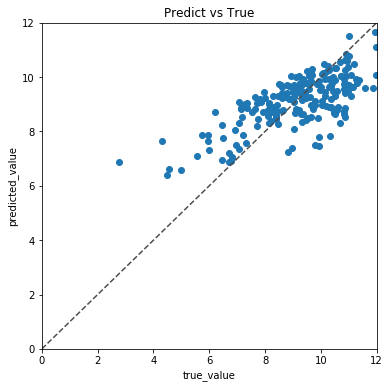

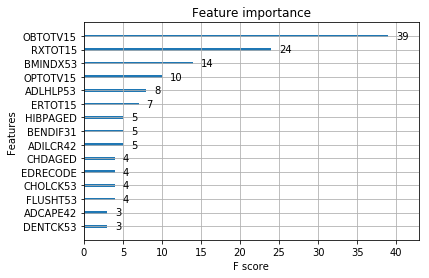

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.4640830010310039, 'observations_count': 1052}
----------------------------------
78
IADLHP31
OPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   25.4s finished


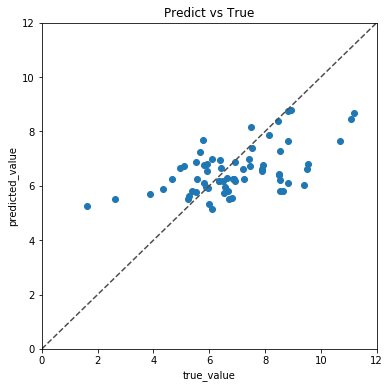

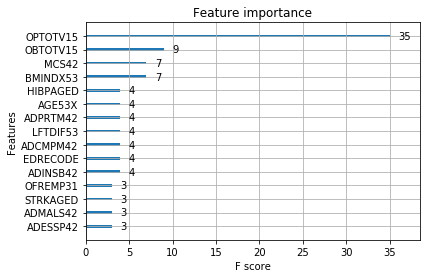

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.2631459892661853, 'observations_count': 327}
----------------------------------
79
IADLHP31
OBVEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   30.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


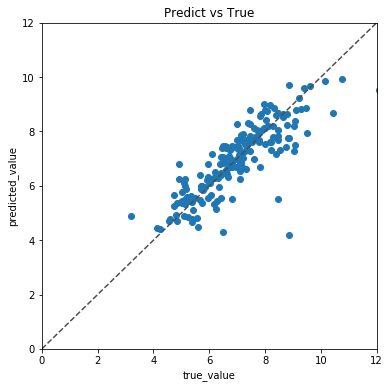

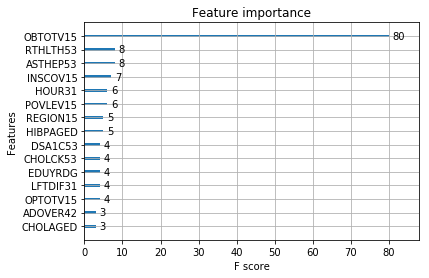

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.7154245599230405, 'observations_count': 980}
----------------------------------
80
IADLHP31
HHAEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   23.2s finished


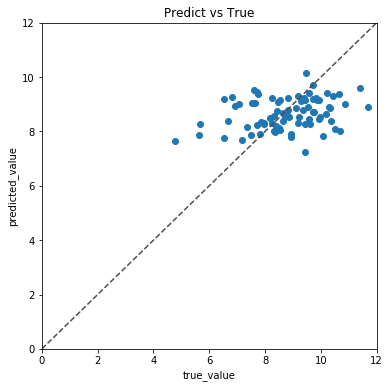

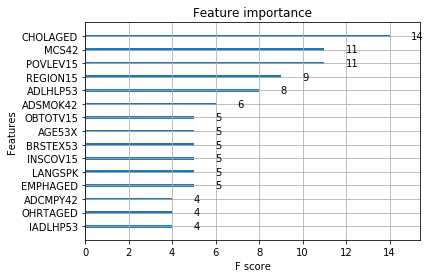

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.09989185423383322, 'observations_count': 398}
----------------------------------
81
IADLHP31
ERTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   26.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


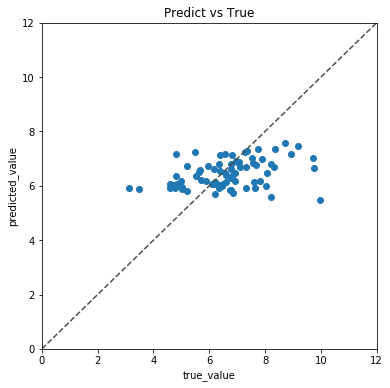

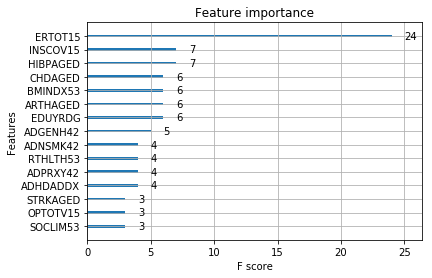

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': 0.13763853343642518, 'observations_count': 374}
----------------------------------
82
IADLHP31
IPTEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   25.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


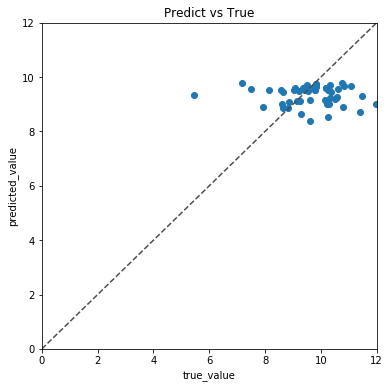

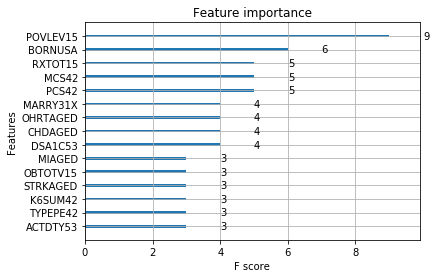

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}
{'test R^2': -0.19020483050213724, 'observations_count': 279}
----------------------------------
83
IADLHP31
RXEXP15
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   25.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


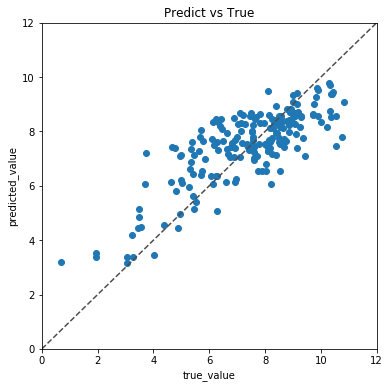

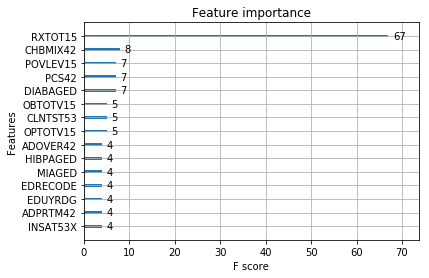

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 65}
{'test R^2': 0.6150197062625082, 'observations_count': 995}


In [12]:
#####
#out model performance
out_dic_summary ={}
n=0
for d in disease_f:
    out_dic_summary[d] = {}
    for e in exp_l:
        print("----------------------------------")
        print(n)
        print(d)
        print(e)
        n+=1
        try :
            out_dic_summary[d][e] = DvsE_out_plot(d,e,df_c,df)
            print(out_dic_summary[d][e])
        except:
            out_dic_summary[d][e] = "NaN"
outt_df_summary = pd.DataFrame(out_dic_summary)
outt_df_summary = outt_df_summary.transpose()

In [13]:
outt_df_summary.to_excel("MEPS_Disease_Expenditure_model_performance_7.12.xlsx")

In [61]:
## overfitting problem: large feature size and small sample size?
## how we treat 0 in response

## compare to previous one where best model is test r^2 0.73 test MAE 0.75; now the OBVEXP column model performs better, 
## ERTOT(medcine), TOTEXP are ok; others sample size small 

In [62]:
# obtotv15 obvexp15
corr

Pregnant  Emphysema  Arthritis  \
Pregnant                                  1.000000   0.217239   0.221633   
Emphysema                                 0.217239   1.000000   0.324405   
Arthritis                                 0.221633   0.324405   1.000000   
High Cholesterol                          0.246454   0.249685   0.364878   
Heart Attack                              0.219934   0.738109   0.335946   
Cancer                                    0.203919   0.575713   0.337932   
Diabetes                                  0.214450   0.508478   0.340357   
High Blood Pressure                       0.244350   0.209119   0.391487   
Asthma                                   -0.015750   0.087281   0.113756   
Attention-deficit/hyperactivity disorder -0.096639  -0.512087  -0.149539   
Coronary Heart Disease                    0.224235   0.693918   0.348650   
Other Heart Disease                       0.198269   0.551121   0.350203   
Stroke                                    0.210374   0.709783   0.333529   
Angina                                    0.215627   0.789386   0.323572   
Patients_Disease_Count                   -0.157463   0.179293  -0.463997   
TOTEXP15                                 -0.051877   0.065139  -0.156275   

                                          High Cholesterol  Heart Attack   \
Pregnant                                          0.246454       0.219934   
Emphysema                                         0.249685       0.738109   
Arthritis                                         0.364878       0.335946   
High Cholesterol                                  1.000000       0.309263   
Heart Attack                                      0.309263       1.000000   
Cancer                                            0.272229       0.535622   
Diabetes                                          0.391312       0.514973   
High Blood Pressure                               0.468717       0.274723   
Asthma                                            0.047701       0.052927   
Attention-deficit/hyperactivity disorder         -0.113088      -0.457481   
Coronary Heart Disease                            0.333757       0.801229   
Other Heart Disease                               0.289947       0.577286   
Stroke                                            0.287565       0.696300   
Angina                                            0.277459       0.779357   
Patients_Disease_Count                           -0.516120       0.002330   
TOTEXP15                                         -0.120669       0.004763   

                                            Cancer  Diabetes  \
Pregnant                                  0.203919  0.214450   
Emphysema                                 0.575713  0.508478   
Arthritis                                 0.337932  0.340357   
High Cholesterol                          0.272229  0.391312   
Heart Attack                              0.535622  0.514973   
Cancer                                    1.000000  0.383797   
Diabetes                                  0.383797  1.000000   
High Blood Pressure                       0.249228  0.372487   
Asthma                                    0.038109  0.056131   
Attention-deficit/hyperactivity disorder -0.344395 -0.308465   
Coronary Heart Disease                    0.514767  0.510865   
Other Heart Disease                       0.446633  0.409561   
Stroke                                    0.527427  0.502006   
Angina                                    0.556803  0.519280   
Patients_Disease_Count                   -0.083479 -0.209349   
TOTEXP15                                 -0.049739 -0.068768   

                                          High Blood Pressure    Asthma  \
Pregnant                                             0.244350 -0.015750   
Emphysema                                            0.209119  0.087281   
Arthritis                                            0.391487  0.113756   
High Cholesterol                                  

In [63]:
#### cluster disease

In [153]:
disease_f = ["CANCERDX", "CHDDX","STRKDX","OHRTDX","HIBPDX","EMPHDX","DIABDX",
#cancer/ coronary heart disease/ stroke/ other heart disease/ high blood pressure/ Emphysema肺气肿/Diabetes糖尿病
            "ARTHDX", "ASTHDX"
             , "ADHDADDX","PREGNT31"]
#           arthrits关节炎/asthma/ 多动症/ pregnant / independent living screener

In [154]:
# look for diagnosis features
hl={}
for x in df_health.columns:
    hl[x] = (len(df[str(x)].unique()))
hcat_columns = []
hnum_columns = []
for k,v in hl.items():
    if v<=3 and ("DX" in k):
        hcat_columns.append(k)
    else:
        hnum_columns.append(k)
hcat_columns = list(set(hcat_columns).union(set(disease_f))) 
hcat_columns.remove("BPMLDX")
len(hcat_columns)

14

In [155]:
#


In [156]:
df_dig = df[hcat_columns]


In [157]:
df_dig_corplot.columns

Index(['EMPHDX', 'DIABDX', 'CHDDX', 'CANCERDX', 'CHOLDX', 'ANGIDX', 'STRKDX',
       'OHRTDX', 'ARTHDX', 'HIBPDX', 'ASTHDX', 'PREGNT31', 'ADHDADDX', 'MIDX'],
      dtype='object')

In [1]:
'''
df_dig = df_dig.fillna(1.5)
df_dig_corplot = df_dig.fillna(0)
df_dig_corplot.columns=["Pregnant", "Emphysema","Arthritis", 
                "High Cholesterol","Heart Attack ", "Cancer","Diabetes", "High Blood Pressure","Asthma", 
                "Attention Disorder",
               "Coronary Heart Disease", "Other Heart Disease","Stroke", "Angina",'sum_disease', 'cluster',
       'TOTEXP15', 'sum_HBP']
X=df_dig
X.shape
'''

'\ndf_dig = df_dig.fillna(1.5)\ndf_dig_corplot = df_dig.fillna(0)\ndf_dig_corplot.columns=["Pregnant", "Emphysema","Arthritis", \n                "High Cholesterol","Heart Attack ", "Cancer","Diabetes", "High Blood Pressure","Asthma", \n                "Attention Disorder",\n               "Coronary Heart Disease", "Other Heart Disease","Stroke", "Angina",\'sum_disease\', \'cluster\',\n       \'TOTEXP15\', \'sum_HBP\']\nX=df_dig\nX.shape\n'

In [159]:

kmeans = KMeans(n_clusters=4, random_state=0).fit(df_dig)


'''
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
'''

'\nbandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)\n\nms = MeanShift(bandwidth=bandwidth, bin_seeding=True)\nms.fit(X)\nlabels = ms.labels_\ncluster_centers = ms.cluster_centers_\n'

In [160]:
df_dig['Total_Disease_Counts'] = (df_dig[hcat_columns] == 1).sum(axis=1)

In [161]:
df_dig["cluster"] = kmeans.labels_
#df_dig["cluster"] = ms.labels_

In [162]:
df_dig.columns=["Pregnant", "Emphysema","Arthritis", 
                "High Cholesterol","Heart Attack ", "Cancer","Diabetes", "High Blood Pressure","Asthma", 
                "Attention Disorder",
               "Coronary Heart Disease", "Other Heart Disease","Stroke", "Angina","sum_disease","cluster"]

In [163]:

df_dig = pd.concat([df_dig, df.TOTEXP15],axis =1)

In [164]:
df_dig.columns

Index(['Pregnant', 'Emphysema', 'Arthritis', 'High Cholesterol',
       'Heart Attack ', 'Cancer', 'Diabetes', 'High Blood Pressure', 'Asthma',
       'Attention Disorder', 'Coronary Heart Disease', 'Other Heart Disease',
       'Stroke', 'Angina', 'sum_disease', 'cluster', 'TOTEXP15'],
      dtype='object')

In [22]:
df_mean = df_dig.groupby(['cluster']).mean()
print("mean across different clusters: ")
print(df_mean.TOTEXP15)
print("median across different clusters: ")
df_median = df_dig.groupby(['cluster']).median()
print(df_median.TOTEXP15)


df_dig[['sum_disease',"cluster"]].groupby(['cluster']).agg(['mean'])


df_mean = df_dig[['sum_disease',"cluster"]].groupby(['cluster']).mean()
print("mean across different clusters: ")
print(df_mean.sum_disease)

mean across different clusters: 
cluster
0     2605.648589
1     3169.524889
2     5042.968241
3    10700.548126
Name: TOTEXP15, dtype: float64
median across different clusters: 
cluster
0     331.0
1     399.0
2    1302.0
3    4460.5
Name: TOTEXP15, dtype: float64
mean across different clusters: 
cluster
0    0.320519
1    0.718523
2    1.845740
3    3.610597
Name: sum_disease, dtype: float64


In [173]:
df_mean = df_dig[['sum_disease',"cluster"]].groupby(['cluster']).mean()
print("mean of sum_disease across clusters: ")
print(df_mean.sum_disease)


df_mean = df_dig.groupby(['cluster']).mean()
print("mean of TOTEXP across clusters: ")
print(df_mean.TOTEXP15)




mean of sum_disease across clusters: 
cluster
0    0.320519
1    0.718523
2    1.845740
3    3.610597
Name: sum_disease, dtype: float64
mean of TOTEXP across clusters: 
cluster
0     2605.648589
1     3169.524889
2     5042.968241
3    10700.548126
Name: TOTEXP15, dtype: float64


In [79]:
#df_dig.sort_values(by=['cluster'])

In [146]:
corr = df_dig.corr()


In [147]:
corr

Pregnant  Emphysema  Arthritis  High Cholesterol  \
Pregnant                1.000000   0.508478   0.693918          0.575713   
Emphysema               0.508478   1.000000   0.510865          0.383797   
Arthritis               0.693918   0.510865   1.000000          0.514767   
High Cholesterol        0.575713   0.383797   0.514767          1.000000   
Heart Attack            0.249685   0.391312   0.333757          0.272229   
Cancer                  0.789386   0.519280   0.756242          0.556803   
Diabetes                0.709783   0.502006   0.653511          0.527427   
High Blood Pressure     0.551121   0.409561   0.620832          0.446633   
Asthma                  0.324405   0.340357   0.348650          0.337932   
Attention Disorder      0.209119   0.372487   0.303959          0.249228   
Coronary Heart Disease  0.087281   0.056131   0.050013          0.038109   
Other Heart Disease     0.217239   0.214450   0.224235          0.203919   
Stroke                 -0.512087  -0.308465  -0.420852         -0.344395   
Angina                  0.738109   0.514973   0.801229          0.535622   
sum_disease            -0.035496  -0.255421  -0.079846         -0.145761   
cluster                 0.179293  -0.209349  -0.090571         -0.083479   
TOTEXP15                0.065139  -0.068768  -0.031203         -0.049739   

                        Heart Attack     Cancer  Diabetes  \
Pregnant                     0.249685  0.789386  0.709783   
Emphysema                    0.391312  0.519280  0.502006   
Arthritis                    0.333757  0.756242  0.653511   
High Cholesterol             0.272229  0.556803  0.527427   
Heart Attack                 1.000000  0.277459  0.287565   
Cancer                       0.277459  1.000000  0.706179   
Diabetes                     0.287565  0.706179  1.000000   
High Blood Pressure          0.289947  0.586812  0.541865   
Asthma                       0.364878  0.323572  0.333529   
Attention Disorder           0.468717  0.235502  0.274849   
Coronary Heart Disease       0.047701  0.052564  0.056576   
Other Heart Disease          0.246454  0.215627  0.210374   
Stroke                      -0.113088 -0.499098 -0.444667   
Angina                       0.309263  0.779357  0.696300   
sum_disease                 -0.673630 -0.028169 -0.088618   
cluster                     -0.516120  0.118733  0.026351   
TOTEXP15                    -0.120669  0.043964 -0.015526   

                        High Blood Pressure    Asthma  Attention Disorder  \
Pregnant                           0.551121  0.324405            0.209119   
Emphysema                          0.409561  0.340357            0.372487   
Arthritis                          0.620832  0.348650            0.303959   
High Cholesterol                   0.446633  0.337932            0.249228   
Heart Attack                       0.289947  0.364878            0.468717   
Cancer                             0.586812  0.323572            0.235502   
Diabetes                           0.541865  0.333529            0.274849   
High Blood Pressure                1.000000  0.350203            0.280562   
Asthma                             0.350203  1.000000            0.391487   
Attention Disorder                 0.280562  0.391487            1.000000   
Coronary Heart Disease             0.067355  0.113756            0.067759   
Other Heart Disease                0.198269  0.221633            0.244350   
Stroke                            -0.328782 -0.149539           -0.081936   
Angina                             0.577286  0.335946            0.274723   
sum_disease                       -0.139467 -0.507804           -0.752245   
cluster                           -0.179530 -0.463997           -0.565450   
TOTEXP15                          -0.063473 -0.156275           -0.150810   

                        Coronary Heart Disease  Other Heart Disease    Stroke  \
Pregnant                              0.087281             0.217239 -0.512087   
Emphyse

In [131]:
corr.Diabetes.sort_values(ascending=False) #高血压 糖尿病 心脏病 ,heart attack,stroke, ANGINA

Diabetes                  1.000000
Angina                    0.519280
Heart Attack              0.514973
Coronary Heart Disease    0.510865
Emphysema                 0.508478
Stroke                    0.502006
Other Heart Disease       0.409561
High Cholesterol          0.391312
Cancer                    0.383797
High Blood Pressure       0.372487
Arthritis                 0.340357
Pregnant                  0.214450
Asthma                    0.056131
Attention Disorder       -0.308465
Name: Diabetes, dtype: float64

In [85]:
df_dig['sum_HBP'] = (df_dig[["High Blood Pressure","Diabetes","Coronary Heart Disease","Stroke"]] == 1).sum(axis=1)

In [2]:
#corr.CHDDX.sort_values(ascending=False)

In [3]:
#corr.CHDDX.sort_values(ascending=False) #coronary heart disease      #doc  7.13:   prem 700 <->1.2k  

In [4]:
#corr.DIABDX.sort_values(ascending=False)

In [92]:
# diabetes vs chddx vs cholestrol vs heart attack vs othear kinds of haert disease vs angina

In [151]:
corr.TOTEXP15.sort_values(ascending=False) #cancer

TOTEXP15                  1.000000
cluster                   0.322759
sum_disease               0.164353
Pregnant                  0.065139
Cancer                    0.043964
Angina                    0.004763
Diabetes                 -0.015526
Arthritis                -0.031203
High Cholesterol         -0.049739
Other Heart Disease      -0.051877
Coronary Heart Disease   -0.061904
High Blood Pressure      -0.063473
Emphysema                -0.068768
Stroke                   -0.095568
Heart Attack             -0.120669
Attention Disorder       -0.150810
Asthma                   -0.156275
Name: TOTEXP15, dtype: float64

In [134]:
corr.columns

Index(['FAMSZEYR', 'Highest Education', 'Office Based Non-Physician Visits',
       'MARRY31X', 'EDUYRDG', 'EDRECODE', 'HIBPAGED', 'CHDAGED', 'ANGIAGED',
       'MIAGED', 'OHRTAGED', 'STRKAGED', 'EMPHAGED', 'CHOLAGED', 'DIABAGED',
       'ARTHAGED', 'Cancer Diagnosis', 'ADHDAGED', 'MOMPRO42', 'DADPRO42',
       'UNHAP42', 'SCHLBH42', 'Age', 'ADUPRO42', 'NERVAF42', 'SIBPRO42',
       'Perceived Health Status', 'SPRPRO42', 'SCHPRO42',
       'Attitude towards Insurance', 'Total Prescribed Medcine', 'CHAPPT42',
       'CHHECR42', 'CHBMIX42', 'BPCHEK53', 'CHOLCK53', 'CHECK53', 'FLUSHT53',
       'PSA53', 'PAPSMR53', 'BRSTEX53', 'MAMOGR53', 'BSTST53', 'CLNTST53',
       'SGMTST53', 'BMINDX53', 'SEATBE53', 'ADPRXY42', 'Family Income Index',
       'ADHECR42', 'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'ADCMPM42',
       'DSA1C53', 'TYPEPE42', 'HOUR31', 'POVLEV15', 'VETSP15X',
       'Total_Expenditure', 'Total Out_patients Visits', 'Working Hours',
       'BMI', 'TOTAL Emergency Room Visits', 'T

In [5]:
#corr.TOTEXP15.sort_values(ascending=False) #total exp

In [95]:
corr.HIBPDX .sort_values(ascending=False)

HIBPDX         1.000000
CHOLDX         0.468717
ARTHDX         0.391487
DIABDX         0.372487
CHDDX          0.303959
OHRTDX         0.280562
STRKDX         0.274849
MIDX           0.274723
CANCERDX       0.249228
PREGNT31       0.244350
ANGIDX         0.235502
EMPHDX         0.209119
ASTHDX         0.067759
ADHDADDX      -0.081936
TOTEXP15      -0.150810
sum_disease   -0.565450
cluster       -0.752245
Name: HIBPDX, dtype: float64

In [96]:
# 1.people with diabetes are twice likely to get coronary disease and stroke than people without diebetes
# 2.cancer vs lung disesea
# ----------
# is it poss

In [97]:
df_dig.sum_disease.describe()

count    35427.000000
mean         1.097045
std          1.629472
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         12.000000
Name: sum_disease, dtype: float64

In [166]:
#df_dig.iloc[:,-:]
corr.columns

Index(['Pregnant', 'Emphysema', 'Arthritis', 'High Cholesterol',
       'Heart Attack ', 'Cancer', 'Diabetes', 'High Blood Pressure', 'Asthma',
       'Attention Disorder', 'Coronary Heart Disease', 'Other Heart Disease',
       'Stroke', 'Angina', 'sum_disease', 'cluster', 'TOTEXP15'],
      dtype='object')

[Text(0.5,1,'Patients with Multiple Disease')]

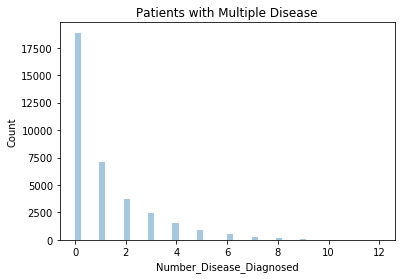

In [169]:
ax = sns.distplot(df_dig.sum_disease, kde=False)
ax.set(xlabel='Number_Disease_Diagnosed', ylabel='Count')
ax.set(title = "Patients with Multiple Disease")


In [6]:
#sns.distplot(df_dig.sum_HBP, kde=False)

In [101]:
df_dig.query('DIABDX == 1').shape[0] #

2809

In [102]:
df_dig.query('DIABDX == 1 & HIBPDX == 1').shape[0]

2165

In [103]:
df_dig.query('DIABDX  == 1 & (CHDDX == 1 | OHRTDX==1 |MIDX ==1) & HIBPDX == 1').shape[0]

777

In [104]:
df_dig.query('STRKDX  == 1 & (CHDDX == 1 | OHRTDX==1 |MIDX ==1) & HIBPDX == 1 & DIABDX == 1').shape[0]

184

In [105]:
df_dig.query('DIABDX == 1 & CHDDX == 1').shape

(476, 18)

In [106]:
df_dig.query('CHDDX == 1').shape

(1290, 18)

In [107]:
df_dig.query('CANCERDX == 1 & EMPHDX == 1').shape

(144, 18)

In [108]:
df_dig.query('PREGNT31  == 1').shape

(398, 18)

In [109]:
df_dig.query('HIBPDX == 1 & PREGNT31 == 1').shape

(33, 18)

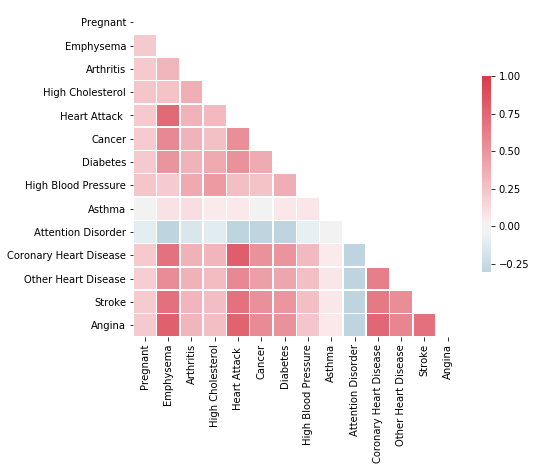

In [130]:
df_dig_corplott = df_dig_corplot.drop(['sum_disease', 'cluster',"sum_HBP","TOTEXP15"], axis=1)
corr = df_dig_corplott.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = 1
# plt corr heatmap
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(230, 9, as_cmap=1)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-0.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .6})


In [ ]:
# emphdc vs angindx
# diabdx vs hbp
# choldx vs strkdx

for cluster 
Notice that K-means gives good linear/corr with exp and sum of disease
if we use mean_shifting for cluster, the linear relation is not that obvious; but still, corr is preserved

In [132]:
corr

FAMSZEYR  Highest Education  \
FAMSZEYR                           1.000000          -0.759162   
Highest Education                 -0.759162           1.000000   
Office Based Non-Physician Visits -0.759292           0.999992   
MARRY31X                           0.639506          -0.790148   
EDUYRDG                           -0.304450           0.134040   
EDRECODE                          -0.499569           0.335298   
HIBPAGED                          -0.301294           0.599935   
CHDAGED                           -0.633928           0.881144   
ANGIAGED                          -0.635254           0.872202   
MIAGED                            -0.606998           0.880051   
OHRTAGED                          -0.663016           0.895592   
STRKAGED                          -0.640351           0.897860   
EMPHAGED                          -0.569342           0.877110   
CHOLAGED                          -0.670461           0.929209   
DIABAGED                          -0.633894           0.898266   
ARTHAGED                          -0.610173           0.876267   
Cancer Diagnosis                  -0.754473           0.913575   
ADHDAGED                          -0.417694           0.735148   
MOMPRO42                           0.006312          -0.196510   
DADPRO42                          -0.064824          -0.160773   
UNHAP42                            0.044905          -0.216648   
SCHLBH42                           0.087957          -0.336087   
Age                                0.031865          -0.203385   
ADUPRO42                           0.038947          -0.222318   
NERVAF42                           0.052805          -0.237718   
SIBPRO42                          -0.182548          -0.271525   
Perceived Health Status            0.045068          -0.248385   
SPRPRO42                           0.066791          -0.268427   
SCHPRO42                           0.079902          -0.342563   
Attitude towards Insurance         0.040049          -0.236677   
...                                     ...                ...   
CHECK53                            0.514753          -0.588034   
FLUSHT53                           0.560371          -0.627262   
PSA53                              0.697021          -0.772564   
PAPSMR53                          -0.159207           0.306298   
BRSTEX53                           0.248964          -0.142912   
MAMOGR53                           0.619975          -0.672069   
BSTST53                            0.539314          -0.628394   
CLNTST53                           0.672963          -0.711697   
SGMTST53                           0.351992          -0.402267   
BMINDX53                           0.042477          -0.074660   
SEATBE53                           0.070361          -0.182616   
ADPRXY42                          -0.156850           0.212134   
Family Income Index               -0.621678           0.642499   
ADHECR42                          -0.197397           0.301388   
PCS42                              0.573761          -0.632986   
MCS42                              0.095582           0.033806   
K6SUM42                           -0.148347           0.003732   
PHQ242                            -0.160654           0.043937   
ADCMPM42                           0.081198          -0.136137   
DSA1C53                            0.120694          -0.183257   
TYPEPE42                           0.057571          -0.088911   
HOUR31                             0.025933          -0.035723   
POVLEV15                          -0.437714           0.372919   
VETSP15X                          -0.140968           0.096772   
Total_Expenditure                 -0.431339           0.297572   
Total Out_patients Visits         -0.494567           0.385605   
Working Hours                     -0.347611           0.226690   
BMI                               -0.314449           0.229241   
TOTAL Emergency Room Visits       -0.269297           0.126176   
Total Off